# Análise das medidas do cálculo coerência do conjunto de dados CohQuAD CoIn en .

Realiza a análise dos cálculos de medida de coerência utilizando BERT.

Utiliza os arquivos resultantes da medição de `X` documentos perturbados e `Y` top K predições.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [ ]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [ ]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Parametrização

## Gerais

In [ ]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCohQuADCoInen_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_COIN_EN"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [ ]:
CONJUNTO_DADOS = 'Cohebert Auto en'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  MODELO_BERT = ['_BERT', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  # MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  MODELO_BERT = ['_BERT', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [ ]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [ ]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERT 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1 
  Equação               : _adj 
  Estratégia            : _mean 
  Filtro                : _svs 
  Resultado             : 0.6 
  Medida                : cman 
  Tempo execução        : 0:00:07

Lista dos resultados ranqueados
1 = ['_BERT', '_large', '_pretreinado', 1, 1, '_adj', '_mean', '_svs', 0.4, 0.45, 0.6, 'cman', 0.6, '0:00:07']
2 = ['_BERT', '_large', '_pretreinado', 1, 1, '_adj', '_max', '_svs', 0.4, 0.45, 0.55, 'cman', 0.55, '0:00:07']
3 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_tap', 0.4, 0.5, 0.55, 'cman', 0.55, '0:00:08']
4 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_svs', 0.4, 0.45, 0.55, 'cman', 0.55, '0:00:07']
5 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_max', '_svs', 0.4, 0.4, 0.5, 'cman', 0.5, '0:00:07']
6 = [

### Escolhendo um resultado diferente do melhor

In [ ]:
# Carrega somente as melhores medidas para Np = 20
MELHOR_DOCUMENTOS_PERTURBADOS = 20
MELHOR_TOP_K_PREDICAO = 20

# Parametros para melhor de 100
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_EQUACAO_MEDIDA = '_ctx'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_ssw'
# MELHOR_RESULTADO = 0.499
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:15'
# lista_resultados = []

# Parametros para melhor de 20
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_EQUACAO_MEDIDA = '_ctx'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_ssw'
# MELHOR_RESULTADO = 0.48
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:08'
# lista_resultados = []

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_adj'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_svs'
# MELHOR_RESULTADO = 0.6
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:05'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [ ]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [ ]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/COHEBERT_EN


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 20.
INFO:root:TERMINADO ORIGINAIS POS: 20.


In [ ]:
lista_documentos_originais.sample(5)

id                                          sentencas  \
5    6  ['How to push and pop elements in a stack data...   
10  11  ['What is a queue and how to dequeue an elemen...   
3    4       ['How to push and pop elements in a stack?']   
11  12  ['What is a stack and how to pop an element fr...   
13  14  ['What is a stack and how to push an element o...   

                                            documento  
5   How to push and pop elements in a stack data s...  
10  What is a queue and how to dequeue an element ...  
3            How to push and pop elements in a stack?  
11  What is a stack and how to pop an element from...  
13  What is a stack and how to push an element on it?

In [ ]:
lista_documentos_originais_pos.sample(5)

id                                      pos_documento
15  16  [[['What', 'is', 'a', 'queue', 'and', 'how', '...
11  12  [[['What', 'is', 'a', 'stack', 'and', 'how', '...
10  11  [[['What', 'is', 'a', 'queue', 'and', 'how', '...
18  19  [[['In', 'a', 'stack', 'does', 'the', 'pop', '...
12  13  [[['What', 'is', 'a', 'queue', 'and', 'how', '...

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [ ]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 20.


#### Criando dados indexados originais

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                                      
1               [How to enqueue elements in a queue?]   
2               [How to dequeue elements in a queue?]   
3                  [How to push elements in a stack?]   
4          [How to push and pop elements in a stack?]   
5   [How to push elements in a stack data structure?]   

                                          documento  
id                                                   
1               How to enqueue elements in a queue?  
2               How to dequeue elements in a queue?  
3                  How to push elements in a stack?  
4          How to push and pop elements in a stack?  
5   How to push elements in a stack data structure?

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                   
1   [[[How, to, enqueue, elements, in, a, queue, ?...
2   [[[How, to, dequeue, elements, in, a, queue, ?...
3   [[[How, to, push, elements, in, a, stack, ?], ...
4   [[[How, to, push, and, pop, elements, in, a, s...
5   [[[How, to, push, elements, in, a, stack, data...

#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 400.
INFO:root:TERMINADO PERTURBADOS POS: 400.


Alguns csv estão com os nomes das colunas errados

In [ ]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [ ]:
lista_documentos_perturbados.sample(5)

id                                         perturbado  \
62    4_pert_2     ['How to throw and pop elements in a stack ?']   
15   1_pert_15              ['How to rank elements in a queue ?']   
95   5_pert_15  ['How to sort elements in a stack data structu...   
88    5_pert_8  ['How to implement elements in a stack data st...   
186  10_pert_6  ['What is a queue and how to handle its elemen...   

                                  documento_perturbado  \
62          How to throw and pop elements in a stack ?   
15                   How to rank elements in a queue ?   
95    How to sort elements in a stack data structure ?   
88   How to implement elements in a stack data stru...   
186    What is a queue and how to handle its element ?   

                                             sentencas  
62   [['How to [MASK] and pop elements in a stack ?...  
15   [['How to [MASK] elements in a queue ?', 'enqu...  
95   [['How to [MASK] elements in a stack data stru...  
88   [['How to [MASK] elements in a stack data stru...  
186  [['What is a queue and how to [MASK] its eleme...

In [ ]:
lista_documentos_perturbados_pos.sample(5)

id                                      pos_documento
73    4_pert_13  [[['How', 'to', 'connect', 'and', 'pop', 'elem...
176   9_pert_16  [[['What', 'is', 'a', 'stack', 'and', 'how', '...
88     5_pert_8  [[['How', 'to', 'implement', 'elements', 'in',...
125    7_pert_5  [[['How', 'to', 'generate', 'elements', 'from'...
398  20_pert_18  [[['In', 'a', 'queue', 'does', 'the', 'enqueue...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [ ]:
 lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 400.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 400.


#### Criando dados indexados perturbados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                  
1_pert_0     [How to place elements in a queue ?]   
1_pert_1   [How to arrange elements in a queue ?]   
1_pert_2  [How to organize elements in a queue ?]   
1_pert_3    [How to manage elements in a queue ?]   
1_pert_4       [How to put elements in a queue ?]   

                           documento_perturbado  \
id                                                
1_pert_0     How to place elements in a queue ?   
1_pert_1   How to arrange elements in a queue ?   
1_pert_2  How to organize elements in a queue ?   
1_pert_3    How to manage elements in a queue ?   
1_pert_4       How to put elements in a queue ?   

                                                  sentencas  
id                                                           
1_pert_0  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_1  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_2  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_3  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_4  [[How to [MASK] elements in a queue ?, enqueue...

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                         
1_pert_0  [[[How, to, place, elements, in, a, queue, ?],...
1_pert_1  [[[How, to, arrange, elements, in, a, queue, ?...
1_pert_2  [[[How, to, organize, elements, in, a, queue, ...
1_pert_3  [[[How, to, manage, elements, in, a, queue, ?]...
1_pert_4  [[[How, to, put, elements, in, a, queue, ?], [...

### 3.2.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 420.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 420.


In [ ]:
lista_documentos_agrupados.sample(5)

id                                          sentencas  \
333  16_pert_17  [What is a queue and how to enqueue and find i...   
175    9_pert_6  [What is a stack and how to represent its elem...   
349  17_pert_12  [How are the operations to hit and pop element...   
334  16_pert_18  [What is a queue and how to enqueue and define...   
18    1_pert_17               [How to group elements in a queue ?]   

                                             documento  classe  
333  What is a queue and how to enqueue and find it...       0  
175  What is a stack and how to represent its eleme...       0  
349  How are the operations to hit and pop elements...       0  
334  What is a queue and how to enqueue and define ...       0  
18                  How to group elements in a queue ?       0

In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 420.


#### Criar dados indexados

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                  
1           [How to enqueue elements in a queue?]   
1_pert_0     [How to place elements in a queue ?]   
1_pert_1   [How to arrange elements in a queue ?]   
1_pert_2  [How to organize elements in a queue ?]   
1_pert_3    [How to manage elements in a queue ?]   

                                      documento  classe  
id                                                       
1           How to enqueue elements in a queue?       1  
1_pert_0     How to place elements in a queue ?       0  
1_pert_1   How to arrange elements in a queue ?       0  
1_pert_2  How to organize elements in a queue ?       0  
1_pert_3    How to manage elements in a queue ?       0

In [ ]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                   
1   [[[How, to, enqueue, elements, in, a, queue, ?...
2   [[[How, to, dequeue, elements, in, a, queue, ?...
3   [[[How, to, push, elements, in, a, stack, ?], ...
4   [[[How, to, push, and, pop, elements, in, a, s...
5   [[[How, to, push, elements, in, a, stack, data...

## 3.3 Carregando o resultado da melhor mensuração

In [ ]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompacta(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 20

In [ ]:
# MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
MODELO_BERT = ['_BERT', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1,20,100]
TOP_K_PREDICAO = [1,20,100]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1],#20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório já existe: /content/COHEBERT_EN/Medicao/.
INFO:root:Diretório já existe: /content/COHEBERT_EN/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/COHEBERT_EN/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 800
Registros CWP: 800
Registros  CG: 800


In [ ]:
dados_mensuracaoCAW.sample(5)

data    arquivo       ccos        ceuc          cman
662  23/09/2022 17:12         17 0.49651131 43.56640566 2069.77868462
672  23/09/2022 17:12         17 0.49651131 43.56640566 2069.77868462
656  23/09/2022 17:12         17 0.49651131 43.56640566 2069.77868462
271  23/09/2022 17:12  7_pert_15 0.48434505 42.06719862 1847.38271429
194  23/09/2022 17:12          5 0.50891373 41.54933739 1886.72318889

In [ ]:
dados_mensuracaoCWP.sample(5)

data     arquivo       ccos        ceuc          cman
352  23/09/2022 17:13           9 0.57061981 41.33745273 2070.55460909
625  23/09/2022 17:13  16_pert_12 0.57258987 40.67846523 2039.46701026
330  23/09/2022 17:13           9 0.57061981 41.33745273 2070.55460909
214  23/09/2022 17:13           6 0.46789948 45.33505391 2143.54566061
329  23/09/2022 17:13    9_pert_4 0.58709700 40.72232576 2039.59315455

In [ ]:
dados_mensuracaoCG.sample(5)

data     arquivo       ccos        ceuc          cman
172  23/09/2022 17:15           5 0.71705511 28.97396336 1341.36873000
732  23/09/2022 17:15          19 0.76784502 28.90201330 1445.91492500
106  23/09/2022 17:15           3 0.70360412 28.45807290 1305.79793750
703  23/09/2022 17:15  18_pert_11 0.76236202 28.42005444 1424.21056357
210  23/09/2022 17:15           6 0.70397692 30.64573924 1448.95103333

In [ ]:
def getMedidasDocumento(df_dados_medida, id_documento):

  # Corrige os tipos dos dados 
  tipos = {"arquivo": str}
  df_dados_medida = df_dados_medida.astype(tipos)
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [ ]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [ ]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  20
Registros Perturbados:  400
Registros Originais:  20
Registros Perturbados:  400
Registros Originais:  20
Registros Perturbados:  400


### Organiza os pares de documentos

In [ ]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id_DO": str}
  df_lista_pares_documentos_medidas = df_lista_pares_documentos_medidas.astype(tipos)

  return df_lista_pares_documentos_medidas

In [ ]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 400
Registros depois: 400
Registros antes: 400
Registros depois: 400
Registros antes: 400
Registros depois: 400


In [ ]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

data_DO id_DO    ccos_DO     ceuc_DO       cman_DO  \
82   23/09/2022 17:12     5 0.50891373 41.54933739 1886.72318889   
342  23/09/2022 17:12    18 0.60920330 39.12629494 1962.30603077   
126  23/09/2022 17:12     7 0.58670093 39.50003433 1969.90231429   
313  23/09/2022 17:12    16 0.59256500 38.68829902 1917.06096667   
330  23/09/2022 17:12    17 0.49651131 43.56640566 2069.77868462   

          data_pertDO   id_pertDO  ccos_pertDO  ceuc_pertDO   cman_pertDO  
82   23/09/2022 17:12    5_pert_2   0.52127544  41.01610904 1859.68505556  
342  23/09/2022 17:12   18_pert_2   0.59355541  40.08952933 2014.94396154  
126  23/09/2022 17:12    7_pert_6   0.48068720  40.57362693 1808.79540000  
313  23/09/2022 17:12  16_pert_13   0.61169207  38.84207106 1951.29432500  
330  23/09/2022 17:12  17_pert_10   0.50747401  43.53109771 2061.39522308

In [ ]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

data_DO id_DO    ccos_DO     ceuc_DO       cman_DO  \
301  23/09/2022 17:13    16 0.56849404 39.82192477 1971.17773462   
385  23/09/2022 17:13    20 0.55954051 41.93794476 2105.78859242   
148  23/09/2022 17:13     8 0.48201116 42.97410855 1993.82026889   
145  23/09/2022 17:13     8 0.48201116 42.97410855 1993.82026889   
293  23/09/2022 17:13    15 0.50470400 43.00272017 2033.60135385   

          data_pertDO   id_pertDO  ccos_pertDO  ceuc_pertDO   cman_pertDO  
301  23/09/2022 17:13   16_pert_1   0.51535622  42.83138358 2030.34389487  
385  23/09/2022 17:13   20_pert_5   0.55934476  41.94828756 2101.43852970  
148  23/09/2022 17:13    8_pert_8   0.59342452  39.89022535 1980.51838000  
145  23/09/2022 17:13    8_pert_5   0.50031477  42.59568965 1960.60501111  
293  23/09/2022 17:13  15_pert_13   0.50430939  43.67427853 2071.17336667

In [ ]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

data_DO id_DO    ccos_DO     ceuc_DO       cman_DO  \
120  23/09/2022 17:15     7 0.79283419 26.46669817 1317.75276250   
233  23/09/2022 17:15    12 0.76855213 28.50153571 1431.09276154   
76   23/09/2022 17:15     4 0.78795410 27.26799202 1362.39027000   
147  23/09/2022 17:15     8 0.71308191 28.74064980 1335.44602000   
370  23/09/2022 17:15    19 0.76784502 28.90201330 1445.91492500   

          data_pertDO   id_pertDO  ccos_pertDO  ceuc_pertDO   cman_pertDO  
120  23/09/2022 17:15    7_pert_0   0.70038561  28.66033983 1302.88862500  
233  23/09/2022 17:15  12_pert_13   0.77654529  28.49252701 1424.08573846  
76   23/09/2022 17:15   4_pert_16   0.78951464  27.22903824 1367.00266000  
147  23/09/2022 17:15    8_pert_7   0.79815522  26.57008266 1321.43086000  
370  23/09/2022 17:15  19_pert_10   0.76755701  29.02385585 1457.00795833

### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [ ]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [ ]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [ ]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : cman
lista_retorno_medido_corretamente: 250


In [ ]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : cman
lista_retorno_medido_corretamente: 294


In [ ]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : cman
lista_retorno_medido_corretamente: 266


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [ ]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : cman
lista_retorno_medido_incorretamente: 550
Equação CWP para a medida para : cman
lista_retorno_medido_incorretamente: 506
Equação CG para a medida para : cman
lista_retorno_medido_incorretamente: 534


#### Acertos das listas

In [ ]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 800
Total de acertos   : 250
Total de erros     : 550
Percentual acerto  : 0.3125


In [ ]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 800
Total de acertos   : 294
Total de erros     : 506
Percentual acerto  : 0.3675


In [ ]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 800
Total de acertos   : 266
Total de erros     : 534
Percentual acerto  : 0.3325


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 250
Sem repetição: 250


Remove as duplicidades dos dados perturbados.

In [ ]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 550
Sem repetição: 295


#### Listas documentos originais e perturbados medidos corretamente

In [ ]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 250
    1 How to enqueue elements in a queue? 1
    2 How to position elements in a queue ? 0
    3 How to enqueue elements in a queue? 1
    4 How to rank elements in a queue ? 0
    5 How to enqueue elements in a queue? 1
    6 How to create elements in a queue ? 0
    7 How to dequeue elements in a queue? 1
    8 How to place elements in a queue ? 0
    9 How to dequeue elements in a queue? 1
    10 How to order elements in a queue ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 550
    1 How to enqueue elements in a queue? 1
    2 How to place elements in a queue ? 0
    3 How to enqueue elements in a queue? 1
    4 How to arrange elements in a queue ? 0
    5 How to enqueue elements in a queue? 1
    6 How to organize elements in a queue ? 0
    7 How to enqueue elements in a queue? 1
    8 How to manage elements in a queue ? 0
    9 How to enqueue elements in a queue? 1
    10 How to put elements in a queue ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [ ]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 125


In [ ]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 125
   0 - How to enqueue elements in a queue? 1
   1 - How to enqueue elements in a queue? 1
   2 - How to enqueue elements in a queue? 1
   3 - How to dequeue elements in a queue? 1
   4 - How to dequeue elements in a queue? 1
   5 - How to dequeue elements in a queue? 1
   6 - How to dequeue elements in a queue? 1
   7 - How to dequeue elements in a queue? 1
   8 - How to dequeue elements in a queue? 1
   9 - How to dequeue elements in a queue? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [ ]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [ ]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 275


In [ ]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 275
   0 - How to enqueue elements in a queue? 1
   1 - How to enqueue elements in a queue? 1
   2 - How to enqueue elements in a queue? 1
   3 - How to enqueue elements in a queue? 1
   4 - How to enqueue elements in a queue? 1
   5 - How to enqueue elements in a queue? 1
   6 - How to enqueue elements in a queue? 1
   7 - How to enqueue elements in a queue? 1
   8 - How to enqueue elements in a queue? 1
   9 - How to enqueue elements in a queue? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [ ]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 275


In [ ]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 275
   0 - How to place elements in a queue ? 0
   1 - How to arrange elements in a queue ? 0
   2 - How to organize elements in a queue ? 0
   3 - How to manage elements in a queue ? 0
   4 - How to put elements in a queue ? 0
   5 - How to sort elements in a queue ? 0
   6 - How to store elements in a queue ? 0
   7 - How to find elements in a queue ? 0
   8 - How to separate elements in a queue ? 0
   9 - How to identify elements in a queue ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [ ]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [ ]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 125


In [ ]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 125
   0 - How to position elements in a queue ? 0
   1 - How to rank elements in a queue ? 0
   2 - How to create elements in a queue ? 0
   3 - How to place elements in a queue ? 0
   4 - How to order elements in a queue ? 0
   5 - How to position elements in a queue ? 0
   6 - How to connect elements in a queue ? 0
   7 - How to rank elements in a queue ? 0
   8 - How to move elements in a queue ? 0
   9 - How to group elements in a queue ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [ ]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [ ]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [ ]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 400.00000000   400.00000000     400.00000000 400.00000000 400.00000000   
mean  199.50000000     0.56900308       0.56932051  -0.00031743   0.04117317   
std   115.61430131     0.04961246       0.05829256   0.06584968   0.05134980   
min     0.00000000     0.44267192       0.41947552  -0.22787849   0.00000000   
25%    99.75000000     0.52449604       0.52125403  -0.02017800   0.00852073   
50%   199.50000000     0.59407757       0.59048653  -0.00759993   0.01841179   
75%   299.25000000     0.60314276       0.61591299   0.01069784   0.05178598   
max   399.00000000     0.61525449       0.67055041   0.19126611   0.22787849   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   400.00000000     400.00000000 400.00000000 400.00000000   
mean     40.25518604      40.19189413   0.06329191   1.36665704   
std       1.57695602       1.83701154   1.98590104   1.44062011   
min      37.94035176      35.08613232  -5.42134476   0.00000000   
25%      39.31975409      38.81686360  -0.83995039   0.33755581   
50%      40.02182701      40.23122264   0.06683138   0.82848033   
75%      41.15333631      41.47069020   0.81545563   1.87550255   
max      43.56640566      44.58702528   7.36585018   7.36585018   

       original cman  perturbado cman      dif cman  difabs cman  
count   400.00000000     400.00000000  400.00000000 400.00000000  
mean   1967.52787848    1944.53183093   22.99604755  39.65417320  
std      60.75031316      74.09432876   47.48353471  34.76255446  
min    1864.72625556    1736.94130000 -120.37910000   0.00000000  
25%    1914.96525000    1883.33369333   -6.33172443  13.11286875  
50%    1974.87804464    1948.94558750   20.98305096  30.75208750  
75%    2018.05484015    2003.44380417   48.33781607  53.79305000  
max    2069.77868462    2109.85077273  179.71273333 179.71273333

Equação CWP

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 400.00000000   400.00000000     400.00000000 400.00000000 400.00000000   
mean  199.50000000     0.54196730       0.53916464   0.00280267   0.03352238   
std   115.61430131     0.04589793       0.04809360   0.05329946   0.04149868   
min     0.00000000     0.44705038       0.42002186  -0.17694854   0.00000000   
25%    99.75000000     0.50048239       0.49524392  -0.01507589   0.00680070   
50%   199.50000000     0.55864267       0.55543857  -0.00551797   0.01460520   
75%   299.25000000     0.57629730       0.57840722   0.01138882   0.04921575   
max   399.00000000     0.59015749       0.62399892   0.14382501   0.17694854   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   400.00000000     400.00000000 400.00000000 400.00000000   
mean     41.77297979      41.89854587  -0.12556609   1.13740865   
std       1.79978113       1.64113713   1.64612343   1.19523551   
min      39.14985064      37.64274338  -4.59377391   0.00000000   
25%      40.56667707      40.72030175  -0.77177664   0.24672872   
50%      41.74657975      42.00371610   0.00497208   0.61561967   
75%      42.98126145      42.88530413   0.53253771   1.62557821   
max      45.67383058      45.87820873   5.50189747   5.50189747   

       original cman  perturbado cman      dif cman  difabs cman  
count   400.00000000     400.00000000  400.00000000 400.00000000  
mean   2048.17032520    2037.22918557   10.94113963  32.20930451  
std      69.06899001      75.09979771   41.10289177  27.73836465  
min    1935.55232500    1857.99808929 -114.79158462   0.00000000  
25%    1992.26694439    1979.85277679  -12.28134916  12.01252798  
50%    2042.59848526    2035.99009145   11.71171035  24.94143944  
75%    2105.75483945    2094.78371731   33.55238235  45.27285453  
max    2188.79038571    2217.97146264  156.72429085 156.72429085

Equação CG

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 400.00000000   400.00000000     400.00000000 400.00000000 400.00000000   
mean  199.50000000     0.75762313       0.75525932   0.00236381   0.02357205   
std   115.61430131     0.03246497       0.03559315   0.03869051   0.03074935   
min     0.00000000     0.69886583       0.64686863  -0.11550753   0.00000000   
25%    99.75000000     0.72402271       0.72178771  -0.00917978   0.00462351   
50%   199.50000000     0.76889273       0.76798160  -0.00410686   0.00878971   
75%   299.25000000     0.78227660       0.78364750   0.00618249   0.03509298   
max   399.00000000     0.79283419       0.81911165   0.11612120   0.11612120   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   400.00000000     400.00000000 400.00000000 400.00000000   
mean     28.21951327      28.23855108  -0.01903781   0.72216706   
std       1.27421288       1.21751681   1.03761554   0.74443067   
min      26.08712554      24.88441658  -2.69451237   0.00000000   
25%      27.39824273      27.53684186  -0.46311991   0.16925883   
50%      28.47523320      28.39179442   0.05446634   0.42301548   
75%      28.86492490      28.87061836   0.37630118   1.05184219   
max      31.08504922      31.26461029   3.57365632   3.57365632   

       original cman  perturbado cman     dif cman  difabs cman  
count   400.00000000     400.00000000 400.00000000 400.00000000  
mean   1382.63709816    1373.24247567   9.39462248  21.90938855  
std      56.12849333      63.12408516  27.28643317  18.75647087  
min    1284.25248750    1230.24601250 -78.30583846   0.00000000  
25%    1339.88805250    1323.16059250  -5.83239375   8.37496490  
50%    1387.84405524    1381.12795606   9.53506107  15.93105136  
75%    1430.72625306    1424.28760935  24.42037125  31.08871644  
max    1486.03088571    1508.79511429 101.25426000 101.25426000

### Estatísticas de todas as Medidas(Transposta)

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       400.00000000  199.50000000 115.61430131    0.00000000   
original ccos   400.00000000    0.56900308   0.04961246    0.44267192   
perturbado ccos 400.00000000    0.56932051   0.05829256    0.41947552   
dif ccos        400.00000000   -0.00031743   0.06584968   -0.22787849   
difabs ccos     400.00000000    0.04117317   0.05134980    0.00000000   
original ceuc   400.00000000   40.25518604   1.57695602   37.94035176   
perturbado ceuc 400.00000000   40.19189413   1.83701154   35.08613232   
dif ceuc        400.00000000    0.06329191   1.98590104   -5.42134476   
difabs ceuc     400.00000000    1.36665704   1.44062011    0.00000000   
original cman   400.00000000 1967.52787848  60.75031316 1864.72625556   
perturbado cman 400.00000000 1944.53183093  74.09432876 1736.94130000   
dif cman        400.00000000   22.99604755  47.48353471 -120.37910000   
difabs cman     400.00000000   39.65417320  34.76255446    0.00000000   

                          25%           50%           75%           max  
documento         99.75000000  199.50000000  299.25000000  399.00000000  
original ccos      0.52449604    0.59407757    0.60314276    0.61525449  
perturbado ccos    0.52125403    0.59048653    0.61591299    0.67055041  
dif ccos          -0.02017800   -0.00759993    0.01069784    0.19126611  
difabs ccos        0.00852073    0.01841179    0.05178598    0.22787849  
original ceuc     39.31975409   40.02182701   41.15333631   43.56640566  
perturbado ceuc   38.81686360   40.23122264   41.47069020   44.58702528  
dif ceuc          -0.83995039    0.06683138    0.81545563    7.36585018  
difabs ceuc        0.33755581    0.82848033    1.87550255    7.36585018  
original cman   1914.96525000 1974.87804464 2018.05484015 2069.77868462  
perturbado cman 1883.33369333 1948.94558750 2003.44380417 2109.85077273  
dif cman          -6.33172443   20.98305096   48.33781607  179.71273333  
difabs cman       13.11286875   30.75208750   53.79305000  179.71273333

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       400.00000000  199.50000000 115.61430131    0.00000000   
original ccos   400.00000000    0.54196730   0.04589793    0.44705038   
perturbado ccos 400.00000000    0.53916464   0.04809360    0.42002186   
dif ccos        400.00000000    0.00280267   0.05329946   -0.17694854   
difabs ccos     400.00000000    0.03352238   0.04149868    0.00000000   
original ceuc   400.00000000   41.77297979   1.79978113   39.14985064   
perturbado ceuc 400.00000000   41.89854587   1.64113713   37.64274338   
dif ceuc        400.00000000   -0.12556609   1.64612343   -4.59377391   
difabs ceuc     400.00000000    1.13740865   1.19523551    0.00000000   
original cman   400.00000000 2048.17032520  69.06899001 1935.55232500   
perturbado cman 400.00000000 2037.22918557  75.09979771 1857.99808929   
dif cman        400.00000000   10.94113963  41.10289177 -114.79158462   
difabs cman     400.00000000   32.20930451  27.73836465    0.00000000   

                          25%           50%           75%           max  
documento         99.75000000  199.50000000  299.25000000  399.00000000  
original ccos      0.50048239    0.55864267    0.57629730    0.59015749  
perturbado ccos    0.49524392    0.55543857    0.57840722    0.62399892  
dif ccos          -0.01507589   -0.00551797    0.01138882    0.14382501  
difabs ccos        0.00680070    0.01460520    0.04921575    0.17694854  
original ceuc     40.56667707   41.74657975   42.98126145   45.67383058  
perturbado ceuc   40.72030175   42.00371610   42.88530413   45.87820873  
dif ceuc          -0.77177664    0.00497208    0.53253771    5.50189747  
difabs ceuc        0.24672872    0.61561967    1.62557821    5.50189747  
original cman   1992.26694439 2042.59848526 2105.75483945 2188.79038571  
perturbado cman 1979.85277679 2035.99009145 2094.78371731 2217.97146264  
dif cman         -12.28134916   11.71171035   33.55238235  156.72429085  
difabs cman       12.01252798   24.94143944   45.27285453  156.72429085

In [ ]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       400.00000000  199.50000000 115.61430131    0.00000000   
original ccos   400.00000000    0.75762313   0.03246497    0.69886583   
perturbado ccos 400.00000000    0.75525932   0.03559315    0.64686863   
dif ccos        400.00000000    0.00236381   0.03869051   -0.11550753   
difabs ccos     400.00000000    0.02357205   0.03074935    0.00000000   
original ceuc   400.00000000   28.21951327   1.27421288   26.08712554   
perturbado ceuc 400.00000000   28.23855108   1.21751681   24.88441658   
dif ceuc        400.00000000   -0.01903781   1.03761554   -2.69451237   
difabs ceuc     400.00000000    0.72216706   0.74443067    0.00000000   
original cman   400.00000000 1382.63709816  56.12849333 1284.25248750   
perturbado cman 400.00000000 1373.24247567  63.12408516 1230.24601250   
dif cman        400.00000000    9.39462248  27.28643317  -78.30583846   
difabs cman     400.00000000   21.90938855  18.75647087    0.00000000   

                          25%           50%           75%           max  
documento         99.75000000  199.50000000  299.25000000  399.00000000  
original ccos      0.72402271    0.76889273    0.78227660    0.79283419  
perturbado ccos    0.72178771    0.76798160    0.78364750    0.81911165  
dif ccos          -0.00917978   -0.00410686    0.00618249    0.11612120  
difabs ccos        0.00462351    0.00878971    0.03509298    0.11612120  
original ceuc     27.39824273   28.47523320   28.86492490   31.08504922  
perturbado ceuc   27.53684186   28.39179442   28.87061836   31.26461029  
dif ceuc          -0.46311991    0.05446634    0.37630118    3.57365632  
difabs ceuc        0.16925883    0.42301548    1.05184219    3.57365632  
original cman   1339.88805250 1387.84405524 1430.72625306 1486.03088571  
perturbado cman 1323.16059250 1381.12795606 1424.28760935 1508.79511429  
dif cman          -5.83239375    9.53506107   24.42037125  101.25426000  
difabs cman        8.37496490   15.93105136   31.08871644  101.25426000

### Divide os pares das medidas das equações em listas 





In [ ]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [ ]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400


### Divide os pares das medidas das equações em listas ordenadas

In [ ]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [ ]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400
400 400


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [ ]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [ ]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [ ]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [ ]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [ ]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [ ]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [ ]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [ ]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [ ]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [ ]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [ ]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [ ]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [ ]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='OD CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='CD CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='OD CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='CD CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='OD CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='OD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Measure of coherence utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='CD CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='CD CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Changed')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [ ]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Changed')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [ ]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Document')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='CD CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='CD CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [ ]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Changed')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [ ]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [ ]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [ ]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [ ]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [ ]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [ ]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [ ]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [ ]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [ ]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [ ]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [ ]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [ ]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")   

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [ ]:
medida = 'cos'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 153 de 400
Percentual de documentos coerentes em relação ao total: 38.25
Acertos Perturbado : 247 de 400
Percentual de documentos incoerentes em relação ao total: 61.75000000000001


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 154 de 400
Percentual de documentos coerentes em relação ao total: 38.5
Acertos Perturbado : 246 de 400
Percentual de documentos incoerentes em relação ao total: 61.5


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 150 de 400
Percentual de documentos coerentes em relação ao total: 37.5
Acertos Perturbado : 250 de 400
Percentual de documentos incoerentes em relação ao total: 62.5


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=True)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to order elements in a queue ?
2;How to move elements in a queue ?
3;How to order elements in a stack ?
4;How to connect and pop elements in a stack ?
5;How to sort elements in a stack data structure ?
6;How to scratch and pop elements in a stack data structure ?
7;How to split elements from a stack ?
8;How to arrange elements in a stack data structure ?
9;What is a stack and how to count its element ?
10;What is a queue and how to select its element ?
11;What is a queue and how to insert an element in it ?
12;What is a stack and how to choose an element from it ?
13;What is a queue and how to retrieve an element in it ?
14;What is a stack and how to execute an element on it ?
15;What is a stack and how to push and keep its elements ?
16;What is a queue and how to enqueue and sort its elements ?
17;How are the operations to scratch and pop elements in a stack implemented ?
18;How are the operations to enqueue and dequeue elements in a queue set ?
19;In a stack does the pop operat

### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





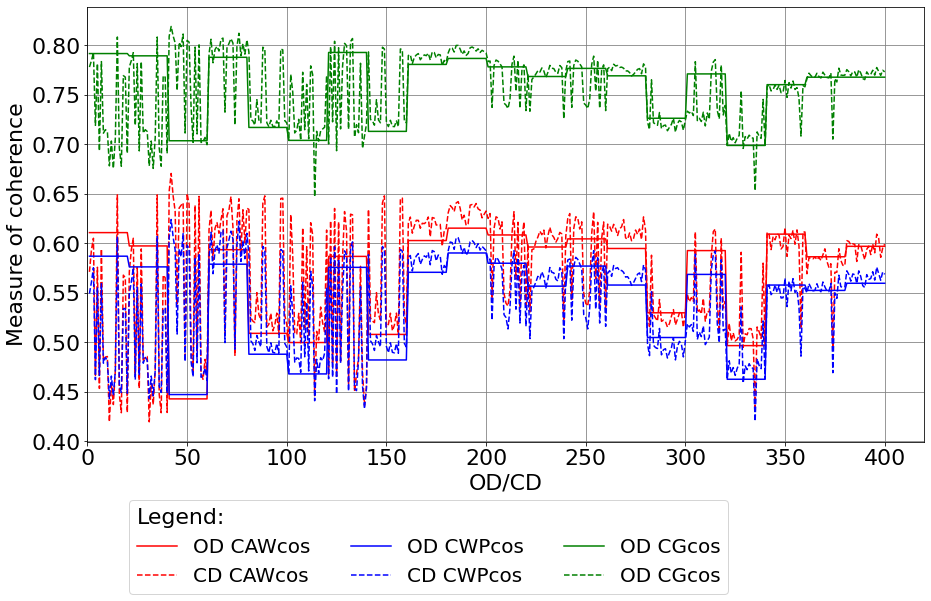

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 16.469268549626833
Diferença entre as equação CWP      : 13.408951597747166
Diferença entre as equação CG       : 9.428819259069044


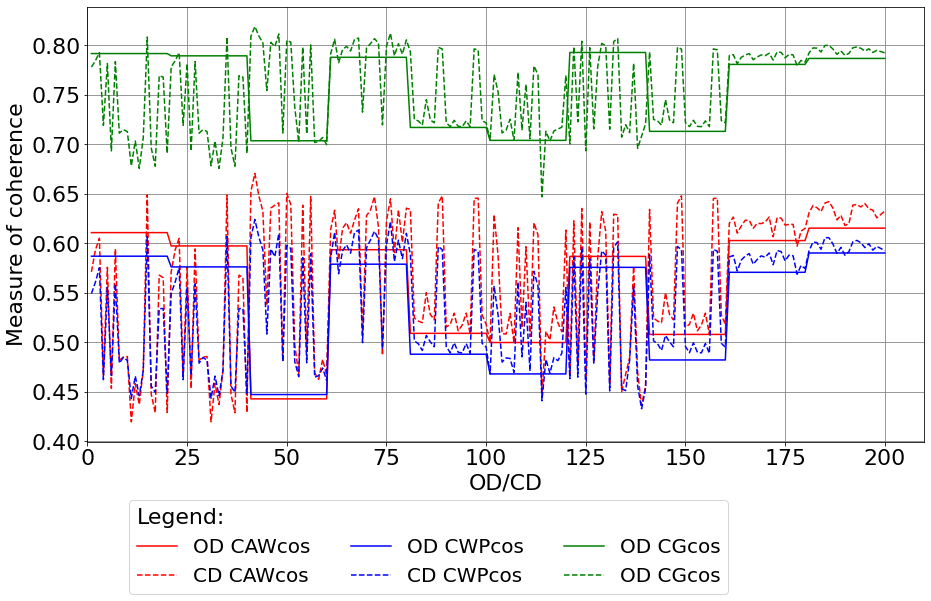

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

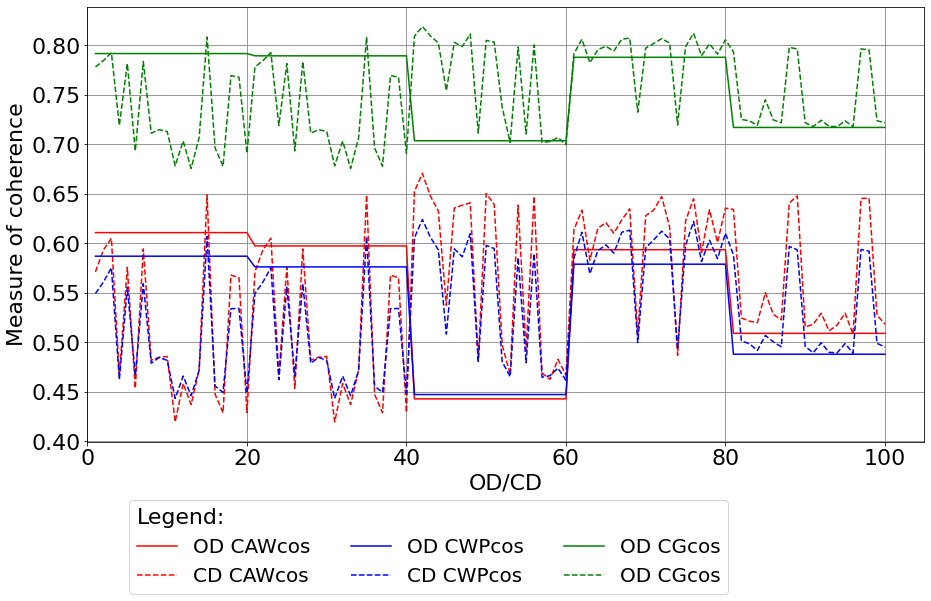

In [ ]:

graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

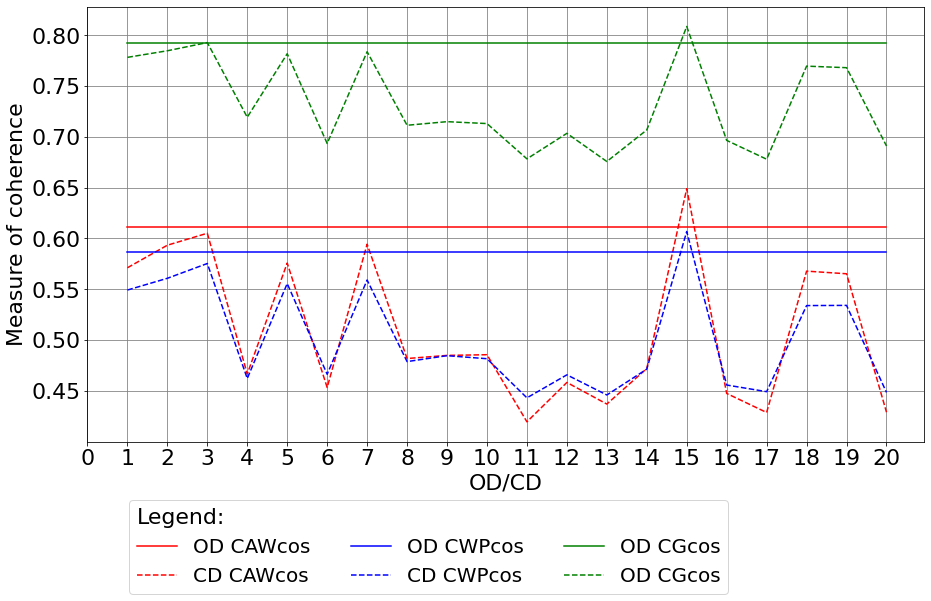

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

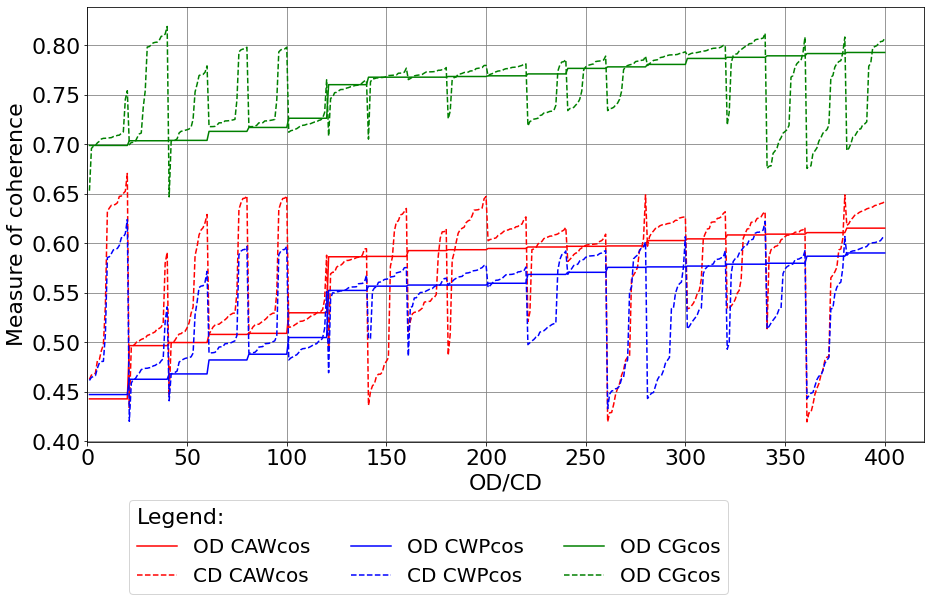

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

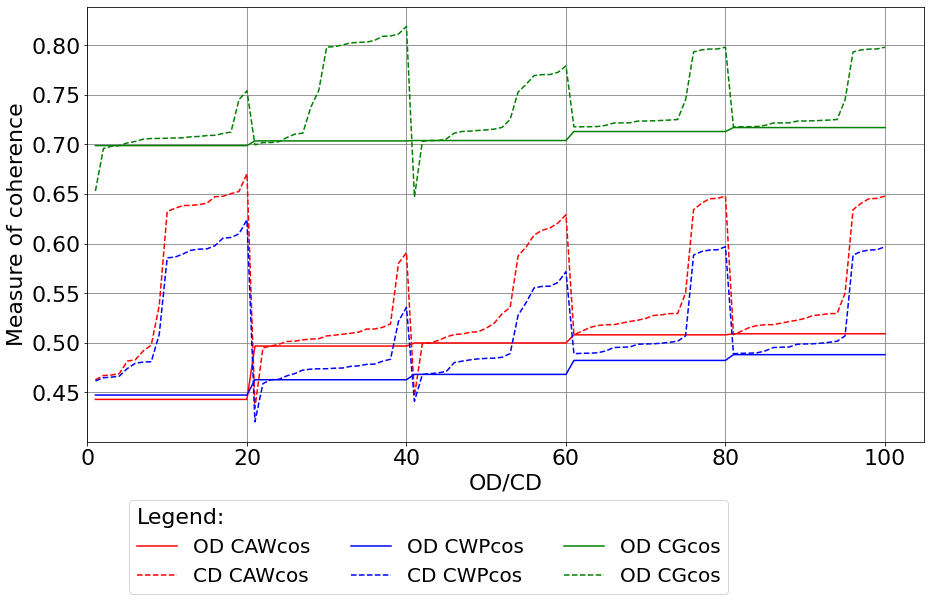

In [ ]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

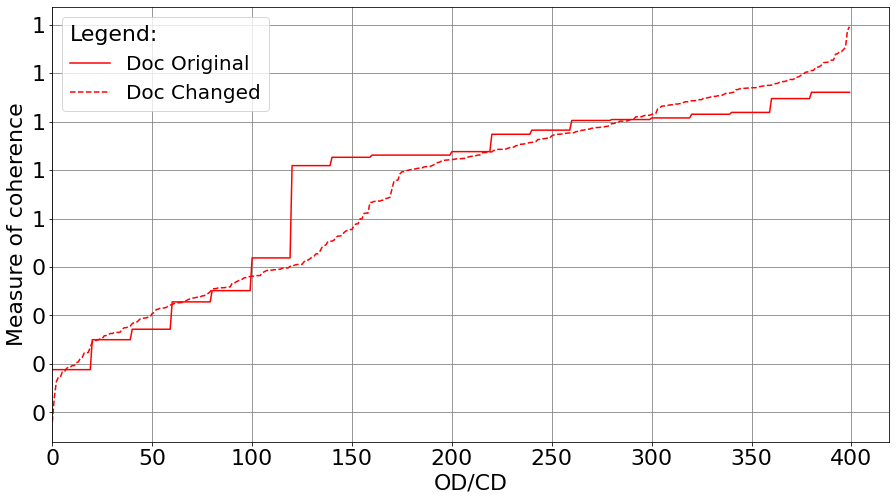

In [ ]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

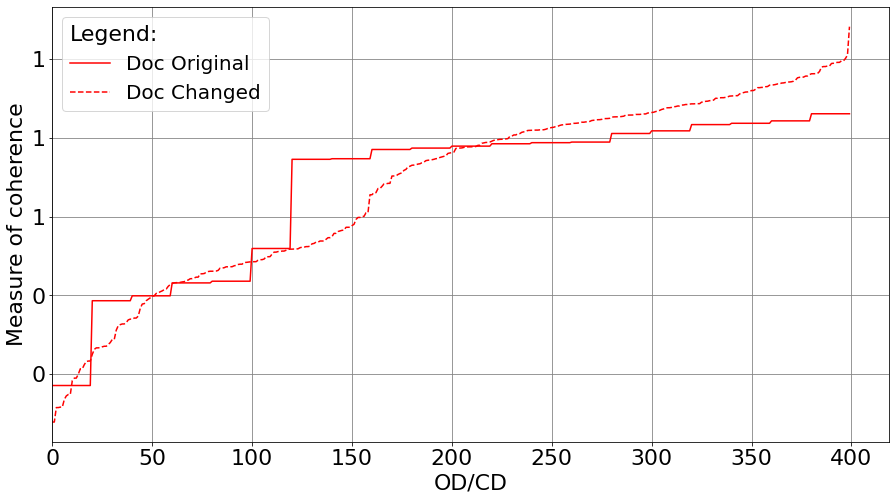

In [ ]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

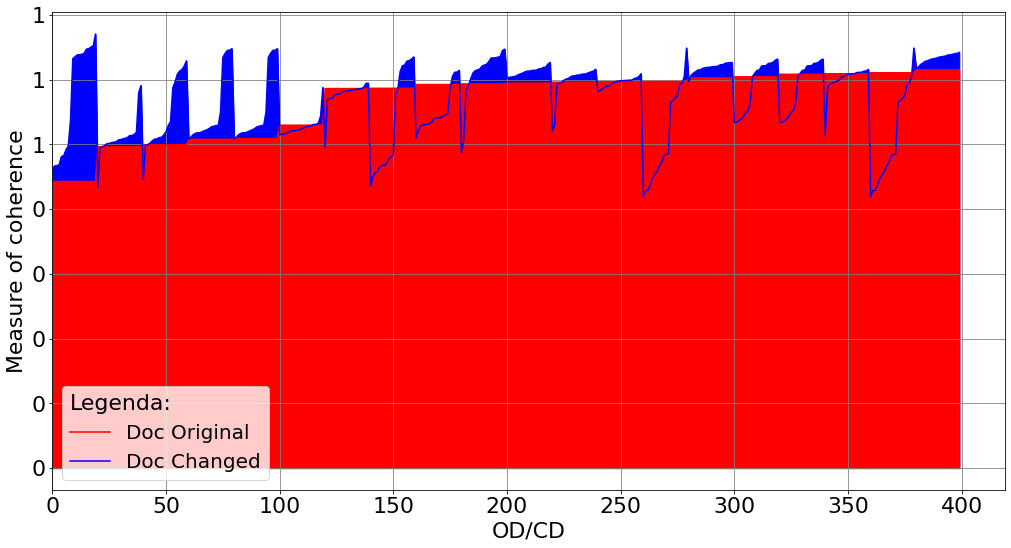

In [ ]:
graficoLinhaMedida2Preenchido('Measure of coherence', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 16.469268549626833

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.1105570305477489, 13, 'In a queue does the enqueue operation occur at which end?']
['15', 0.19610001146793354, 6, 'What is a stack and how to push and pop its elements?']
['19', 0.21382286941463324, 7, 'In a stack does the pop operation occur at which end?']
['18', 0.21944237328492677, 18, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 0.31586788272640354, 12, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 0.9764849367466844, 3, 'How to push and pop elements in a stack data structure?']
['7', 1.6258489816848725, 8, 'How to pop elements from a stack?']
['2', 1.8796617262331499, 14, 'How to deq

##### Usando CAW onde Cm(pertDO)>Cm(DO) *


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 8.298120826990786

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 0.01805874163454224, 7, 'In a stack does the pop operation occur at which end?']
['18', 0.021476851059840096, 18, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['1', 0.03811996323721745, 19, 'How to enqueue elements in a queue?']
['20', 0.04424304853786143, 13, 'In a queue does the enqueue operation occur at which end?']
['2', 0.05934286117553722, 14, 'How to dequeue elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 0.5188379122151271, 10, 'How to push and pop elements in a stack?']
['5', 0.8764975691835079, 5, 'Ho

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
# id_documento = "3"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> order(>CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> find(>CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> separate(>CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> connect(>CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> sort(>CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> create(>CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> manipulate(>CAWcos(pertDO)=0,4915693988)] - VERB/VER

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 8.171147722636062

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.0009162185920609245, 5, 'How to push elements in a stack data structure?']
['9', 0.00567538738250728, 15, 'What is a stack and how to push its element?']
['6', 0.05413655564188946, 3, 'How to push and pop elements in a stack data structure?']
['17', 0.0645727596890468, 2, 'How are the operations to push and pop elements in a stack implemented?']
['20', 0.06631398200988747, 13, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11', 0.5176574001088737, 17, 'What is a queue and how to dequeue an element in it?']
['16',

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: How to push elements in a stack data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to sort elements in a stack data structure ? [push(>CAWcos(DO)=0,5089137289) -> sort(CAWcos(pertDO)=0,5079975103)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack data structure ? [push(CAWcos(DO)=0,5089137289) -> arrange(>CAWcos(pertDO)=0,5114813306)] - VERB/VERB-1-0
  3 - How to write elements in a stack data structure ? [push(CAWcos(DO)=0,5089137289) -> write(>CAWcos(pertDO)=0,5152472622)] - VERB/VERB-1-0
  4 - How to separate elements in a stack data structure ? [push(CAWcos(DO)=0,5089137289) -> separate(>CAWcos(pertDO)=0,5172628487)] - VERB/VERB-1-0
  5 - How to describe elements in a stack data structure ? [push(CAWcos(DO)=0,5089137289) -> describe(>CAWcos(pertDO)=0,5180540726)] - VERB/VERB-1-0
  6 - How to index elements in a stack data structure ? [push(CAWcos(DO)=0,5089137289) -> index(>CAWcos(pertDO)=0,5181158193)] - VERB/NOUN-0-0
  7 - How t

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5
DO: How to push elements in a stack data structure?
     SCONJ PART VERB NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5_pert_0;How to store elements in a stack data structure ?;push;VERB;0,5089137289;0,4878175810;0,7170551099;store;VERB;0,6341960000;0,5883430110;0,7933973312;0,0714398921;0;1
5_pert_1;How to organize elements in a stack data structure ?;push;VERB;0,5089137289;0,4878175810;0,7170551099;organize;VERB;0,5244466724;0,5013647084;0,7252028987;0,0608092956;0;1
5_pert_2;How to manage elements in a stack data structure ?;push;VERB;0,5089137289;0,4878175810;0,7170551099;manage;VERB;0,5212754409;0,4983613152;0,7236250222;0,0586123914;0;1
5_pert_3;How to represent elements in a stack data structure ?;push;VERB;0,5089137289;0,4878175810;0,7170551099;represent;VERB;0,5197248604;0,4916268000;0,7193525448

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 13.408951597747166

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.1425148860974753, 20, 'What is a queue and how to enqueue its element?']
['20', 0.14963270768974823, 11, 'In a queue does the enqueue operation occur at which end?']
['19', 0.16203058456934089, 7, 'In a stack does the pop operation occur at which end?']
['18', 0.21180482741936563, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['14', 0.2249968988008979, 10, 'What is a stack and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 0.9661798076525043, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['7', 1.4589270923918642, 14, 'How to pop elements from a stack?']
['2', 1.5563768502657431, 15, 'How to 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 6.1439426032137625

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.017444793339614018, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['1', 0.01986428137336449, 19, 'How to enqueue elements in a queue?']
['2', 0.03068375587463379, 15, 'How to dequeue elements in a queue?']
['11', 0.03579952625127958, 18, 'What is a queue and how to dequeue an element in it?']
['15', 0.055450372588940144, 6, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 0.3754231658246794, 17, 'How to push and pop elements in a stack?']
['5', 0.6460554122924813, 5, 'How

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to find elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> find(>CWPcos(pertDO)=0,4612955031)] - VERB/VERB-1-0
  2 - How to connect elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> connect(>CWPcos(pertDO)=0,4645378393)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> separate(>CWPcos(pertDO)=0,4651108677)] - VERB/VERB-1-0
  4 - How to order elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> order(>CWPcos(pertDO)=0,4661453345)] - VERB/VERB-1-0
  5 - How to create elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> create(>CWPcos(pertDO)=0,4737560845)] - VERB/VERB-1-0
  6 - How to manipulate elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> manipulate(>CWPcos(pertDO)=0,4791309333)] - VERB/VERB-1-0
  7 - How to use elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> use(>CWPcos(pertDO)=0,4803760238)] - VERB/VERB-

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 7.265008994533396

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00030205226861523826, 10, 'What is a stack and how to push an element on it?']
['9', 0.002004726908423682, 13, 'What is a stack and how to push its element?']
['10', 0.0027173302390357534, 20, 'What is a queue and how to enqueue its element?']
['20', 0.006915573369372985, 11, 'In a queue does the enqueue operation occur at which end?']
['6', 0.027114381618571992, 3, 'How to push and pop elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11', 0.4710271088525838, 18, 'What is a queue and how to dequeue an element in it?']
['16', 0.883041

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to execute an element on it ? [push(>CWPcos(DO)=0,5577448244) -> execute(CWPcos(pertDO)=0,5574427721)] - VERB/VERB-1-0
  2 - What is a stack and how to construct an element on it ? [push(CWPcos(DO)=0,5577448244) -> construct(>CWPcos(pertDO)=0,5601501014)] - VERB/VERB-1-0
  3 - What is a stack and how to load an element on it ? [push(CWPcos(DO)=0,5577448244) -> load(>CWPcos(pertDO)=0,5612344551)] - VERB/VERB-1-0
  4 - What is a stack and how to build an element on it ? [push(CWPcos(DO)=0,5577448244) -> build(>CWPcos(pertDO)=0,5632937302)] - VERB/VERB-1-0
  5 - What is a stack and how to have an element on it ? [push(CWPcos(DO)=0,5577448244) -> have(>CWPcos(pertDO)=0,5645030576)] - VERB/VERB-1-0
  6 - What is a stack and how to represent an element on it ? [push(CWPcos(DO)=0,5577448244) -> represent(>CWPcos(pertDO)=0,565802932

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a stack and how to put an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;put;VERB;0,6192863633;0,5697919325;0,7764330277;0,2460652888;0;1
14_pert_1;What is a stack and how to place an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;place;VERB;0,6169475690;0,5722487191;0,7778891829;0,1942972094;0;1
14_pert_2;What is a stack and how to implement an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;implement;VERB;0,6121923799;0,5665102674;0,7744744374;0,0522025973;0;1
14_pert_3;What is a stack and how to define an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;define;VERB;0,6190907856;0,5774

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 9.428819259069044

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.09014659623304999, 9, 'In a queue does the enqueue operation occur at which end?']
['19', 0.10957518677848077, 8, 'In a stack does the pop operation occur at which end?']
['14', 0.1343277967893156, 11, 'What is a stack and how to push an element on it?']
['18', 0.13800117346857232, 7, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['9', 0.15221956643191215, 15, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 0.679952437631212, 12, 'What is a queue and how to enqueue and dequeue its elements?']
['7', 0.9979386630002409, 20, 'How to pop elements from a stack?']
['2', 1.186466694009141, 18, 'How to dequeue e

###### Usando CGP onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 4.2416479417870665

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.009986621992928768, 7, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['1', 0.01761838048696518, 19, 'How to enqueue elements in a queue?']
['2', 0.022215552628040314, 18, 'How to dequeue elements in a queue?']
['19', 0.03705637156963337, 8, 'In a stack does the pop operation occur at which end?']
['15', 0.04476937307761275, 6, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.21722867792206102, 1, 'How are the operations to push and pop elements in a stack implemented?']
['5

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to find elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> find(CGcos(pertDO)=0,6995989825)] - VERB/VERB-1-0
  2 - How to connect elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> connect(CGcos(pertDO)=0,7018327564)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> separate(CGcos(pertDO)=0,7019377626)] - VERB/VERB-1-0
  4 - How to order elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> order(CGcos(pertDO)=0,7027993700)] - VERB/VERB-1-0
  5 - How to create elements in a stack ? [push(CGcos(DO)=0,7036041166) -> create(>CGcos(pertDO)=0,7069749818)] - VERB/VERB-1-0
  6 - How to manipulate elements in a stack ? [push(CGcos(DO)=0,7036041166) -> manipulate(>CGcos(pertDO)=0,7104687942)] - VERB/VERB-1-0
  7 - How to sort elements in a stack ? [push(CGcos(DO)=0,7036041166) -> sort(>CGcos(pertDO)=0,7114053844)] - VERB/VERB-1-0
  8 - Ho

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

###### Usando CGP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 5.187171317281973

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00018393993377685547, 11, 'What is a stack and how to push an element on it?']
['9', 0.0011645392938093302, 15, 'What is a stack and how to push its element?']
['20', 0.0039013723532359545, 9, 'In a queue does the enqueue operation occur at which end?']
['3', 0.008247594814747572, 2, 'How to push elements in a stack?']
['17', 0.04951695845063253, 1, 'How are the operations to push and pop elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11', 0.3044652829949671, 14, 'What is a queue and how to dequeue an element in it?']
['16', 0.629476918

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to execute an element on it ? [push(>CGcos(DO)=0,7692333231) -> execute(CGcos(pertDO)=0,7690493831)] - VERB/VERB-1-0
  2 - What is a stack and how to construct an element on it ? [push(CGcos(DO)=0,7692333231) -> construct(>CGcos(pertDO)=0,7706754208)] - VERB/VERB-1-0
  3 - What is a stack and how to load an element on it ? [push(CGcos(DO)=0,7692333231) -> load(>CGcos(pertDO)=0,7713220028)] - VERB/VERB-1-0
  4 - What is a stack and how to build an element on it ? [push(CGcos(DO)=0,7692333231) -> build(>CGcos(pertDO)=0,7725568964)] - VERB/VERB-1-0
  5 - What is a stack and how to have an element on it ? [push(CGcos(DO)=0,7692333231) -> have(>CGcos(pertDO)=0,7732839447)] - VERB/VERB-1-0
  6 - What is a stack and how to represent an element on it ? [push(CGcos(DO)=0,7692333231) -> represent(>CGcos(pertDO)=0,7740541330)] - VERB/V

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a stack and how to put an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;put;VERB;0,6192863633;0,5697919325;0,7764330277;0,2460652888;0;1
14_pert_1;What is a stack and how to place an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;place;VERB;0,6169475690;0,5722487191;0,7778891829;0,1942972094;0;1
14_pert_2;What is a stack and how to implement an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;implement;VERB;0,6121923799;0,5665102674;0,7744744374;0,0522025973;0;1
14_pert_3;What is a stack and how to define an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;define;VERB;0,6190907856;0,5774

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 5.187171317281973

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.015294703570279178, 13, 'In a queue does the enqueue operation occur at which end?']
['9', 0.0237944036722183, 15, 'What is a stack and how to push its element?']
['10', 0.02682482004165654, 20, 'What is a queue and how to enqueue its element?']
['14', 0.03194091469049454, 11, 'What is a stack and how to push an element on it?']
['15', 0.058193596700827355, 6, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 0.14005690088702571, 4, 'How to pop elements in a stack data structure?']
['7', 0.1506307486976896, 8, 'How to pop elements from a stack?']
['2', 0.17779871927840363, 14, 'How 

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 5.187171317281973

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.006668563072497968, 18, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['19', 0.008114671165292853, 7, 'In a stack does the pop operation occur at which end?']
['20', 0.01227254488251428, 13, 'In a queue does the enqueue operation occur at which end?']
['12', 0.01983831077814102, 12, 'What is a stack and how to pop an element from it?']
['16', 0.02188044786453247, 9, 'What is a queue and how to enqueue and dequeue its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.09435719294616818, 2, 'How are the operations to push and pop ele

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> order(>CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> find(>CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> separate(>CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> connect(>CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> sort(>CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> create(>CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> manipulate(>CAWcos(pertDO)=0,4915693988)] - VERB/VER

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 5.187171317281973

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.0009162185920609245, 5, 'How to push elements in a stack data structure?']
['9', 0.00567538738250728, 15, 'What is a stack and how to push its element?']
['15', 0.014645297080278397, 6, 'What is a stack and how to push and pop its elements?']
['20', 0.015294703570279178, 13, 'In a queue does the enqueue operation occur at which end?']
['6', 0.05381931770931586, 3, 'How to push and pop elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['18', 0.09560965460080373, 18, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['4'

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> move(CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> process(CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> connect(CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> rank(CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> sort(CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> position(CAWcos(pertDO)=0,458210143

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
1_pert_4;How to put elements in a queue ?;enqueue;VERB;0

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 5.187171317281973

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.0154597547921268, 20, 'What is a queue and how to enqueue its element?']
['20', 0.01637325639074505, 11, 'In a queue does the enqueue operation occur at which end?']
['14', 0.02031454711388314, 10, 'What is a stack and how to push an element on it?']
['9', 0.02200460542332039, 13, 'What is a stack and how to push its element?']
['15', 0.04629410669589651, 6, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 0.11474561281502249, 4, 'How to pop elements in a stack data structure?']
['2', 0.1330055384231465, 15, 'How to dequeue elements in a queue?']
['7', 0.1429494619535815, 14, 'How 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 5.187171317281973

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.006899306407341599, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['11', 0.012715583428358435, 18, 'What is a queue and how to dequeue an element in it?']
['19', 0.015373890598614937, 7, 'In a stack does the pop operation occur at which end?']
['10', 0.0154597547921268, 20, 'What is a queue and how to enqueue its element?']
['13', 0.015566974878311157, 16, 'What is a queue and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.07313893727221327, 2, 'How are the operations to push and pop elements in a stac

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> order(>CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> find(>CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> separate(>CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> connect(>CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> sort(>CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> create(>CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> manipulate(>CAWcos(pertDO)=0,4915693988)] - VERB/VER

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 5.187171317281973

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00030205226861523826, 10, 'What is a stack and how to push an element on it?']
['9', 0.002004726908423682, 13, 'What is a stack and how to push its element?']
['10', 0.002303894541480278, 20, 'What is a queue and how to enqueue its element?']
['20', 0.004316345308766234, 11, 'In a queue does the enqueue operation occur at which end?']
['15', 0.022655986058406352, 6, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.08317087468877266, 7, 'In a stack does the pop operation occur at which end?']
['4', 0.0859574344837003, 17,

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> move(CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> process(CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> connect(CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> rank(CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> sort(CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> position(CAWcos(pertDO)=0,458210143

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
1_pert_4;How to put elements in a queue ?;enqueue;VERB;0

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 5.187171317281973

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.009746576348940494, 9, 'In a queue does the enqueue operation occur at which end?']
['14', 0.01209888549951399, 11, 'What is a stack and how to push an element on it?']
['9', 0.012711053544824713, 15, 'What is a stack and how to push its element?']
['10', 0.013163051821968752, 16, 'What is a queue and how to enqueue its element?']
['15', 0.038827897264407274, 6, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 0.08507331795990469, 4, 'How to pop elements in a stack data structure?']
['7', 0.09929525258485228, 20, 'How to pop elements from a stack?']
['2', 0.11382261816470418, 18, 'Ho

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 5.187171317281973

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.004227629729679716, 7, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['19', 0.009120921293894413, 8, 'In a stack does the pop operation occur at which end?']
['20', 0.009746576348940494, 9, 'In a queue does the enqueue operation occur at which end?']
['11', 0.0108678295062139, 14, 'What is a queue and how to dequeue an element in it?']
['12', 0.011214288381429793, 10, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 0.0553109220096043, 1, 'How are the operations to push and pop elements in a 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> order(>CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> find(>CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> separate(>CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> connect(>CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> sort(>CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> create(>CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> manipulate(>CAWcos(pertDO)=0,4915693988)] - VERB/VER

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 5.187171317281973

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00018393993377685547, 11, 'What is a stack and how to push an element on it?']
['9', 0.0011645392938093302, 15, 'What is a stack and how to push its element?']
['20', 0.002474367618560791, 9, 'In a queue does the enqueue operation occur at which end?']
['3', 0.004005134105682373, 2, 'How to push elements in a stack?']
['15', 0.01409767969296527, 6, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 0.06258675417241955, 8, 'In a stack does the pop operation occur at which end?']
['4', 0.06835953434929243, 17, 'How to push and p

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> move(CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> process(CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> connect(CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> rank(CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> sort(CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> position(CAWcos(pertDO)=0,458210143

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
1_pert_4;How to put elements in a queue ?;enqueue;VERB;0

## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [ ]:
medida = 'euc'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 189 de 400
Percentual de documentos coerentes em relação ao total: 47.25
Acertos Perturbado : 211 de 400
Percentual de documentos incoerentes em relação ao total: 52.75


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 199 de 400
Percentual de documentos coerentes em relação ao total: 49.75
Acertos Perturbado : 201 de 400
Percentual de documentos incoerentes em relação ao total: 50.24999999999999


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 190 de 400
Percentual de documentos coerentes em relação ao total: 47.5
Acertos Perturbado : 210 de 400
Percentual de documentos incoerentes em relação ao total: 52.5


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to order elements in a queue ?
2;How to move elements in a queue ?
3;How to connect elements in a stack ?
4;How to connect and pop elements in a stack ?
5;How to sort elements in a stack data structure ?
6;How to scratch and pop elements in a stack data structure ?
7;How to split elements from a stack ?
8;How to write elements in a stack data structure ?
9;What is a stack and how to count its element ?
10;What is a queue and how to select its element ?
11;What is a queue and how to retrieve an element in it ?
12;What is a stack and how to choose an element from it ?
13;What is a queue and how to insert an element in it ?
14;What is a stack and how to construct an element on it ?
15;What is a stack and how to push and drop its elements ?
16;What is a queue and how to enqueue and order its elements ?
17;How are the operations to scratch and pop elements in a stack implemented ?
18;How are the operations to enqueue and dequeue elements in a queue set ?
19;In a stack does the pop ope

### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





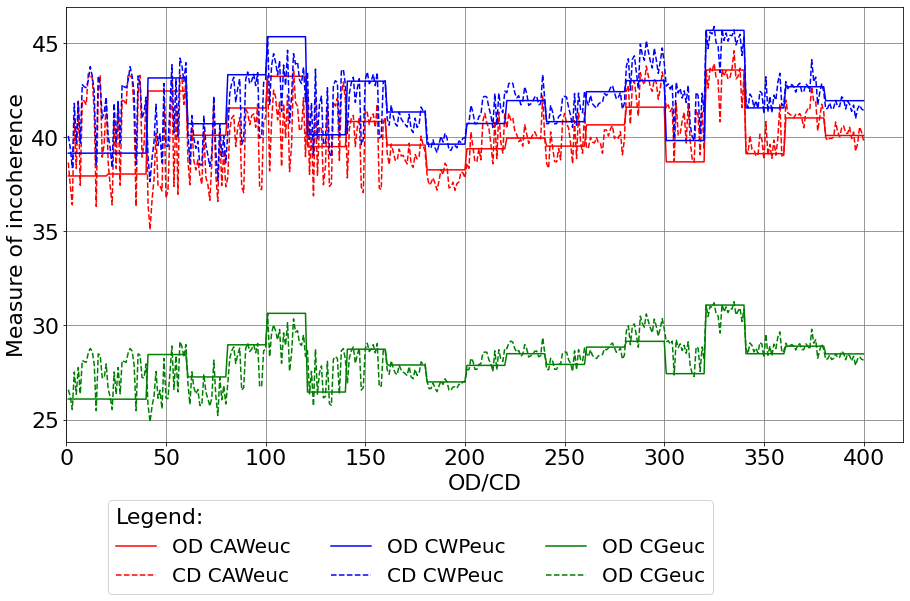

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 546.662814341577
Diferença absoluta entre as medidas equação CWP : 454.9634582252345
Diferença absoluta entre as medidas equação CG  : 288.86682417118817


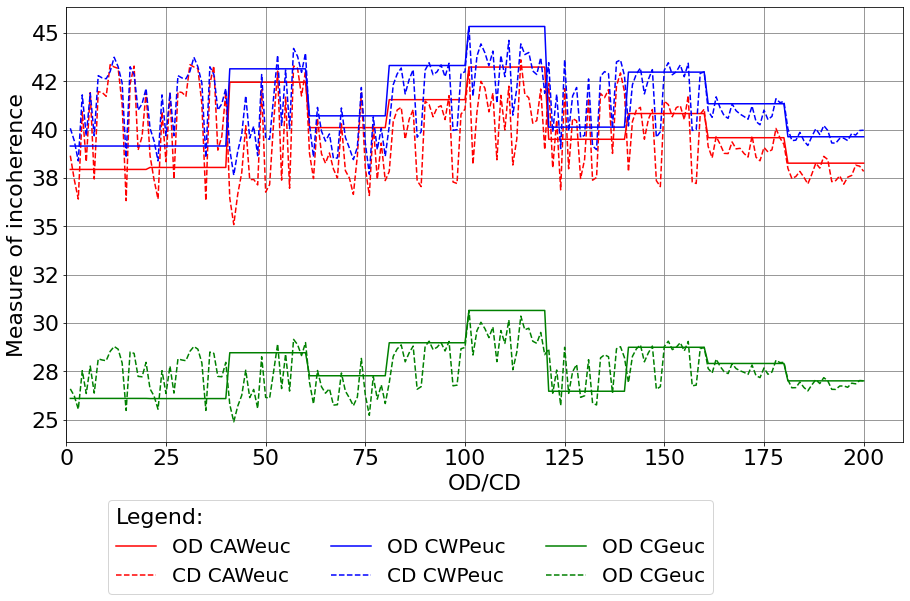

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

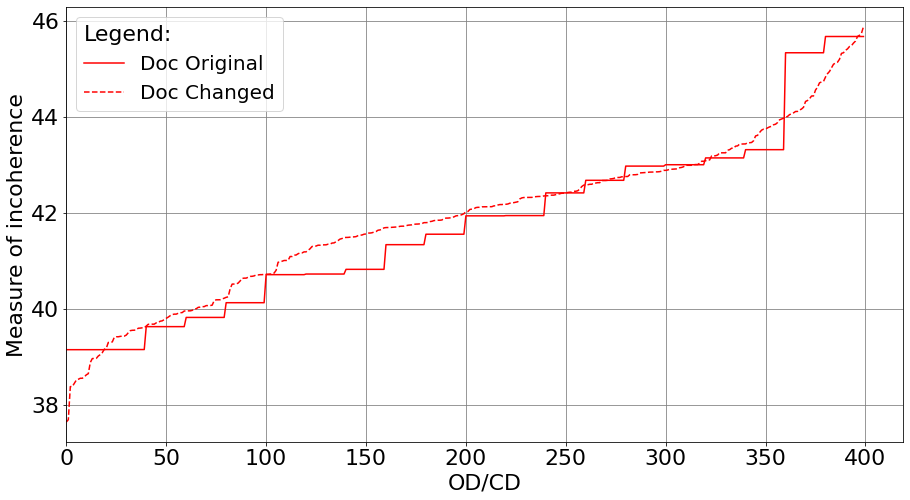

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

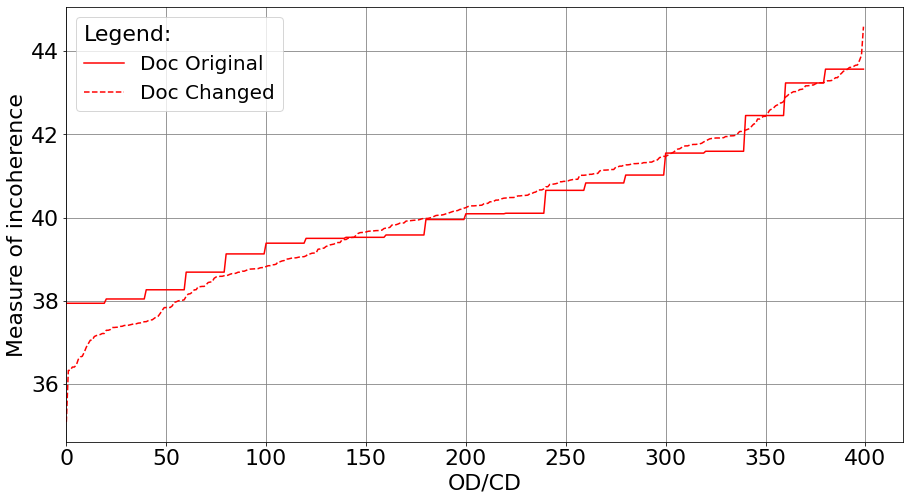

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

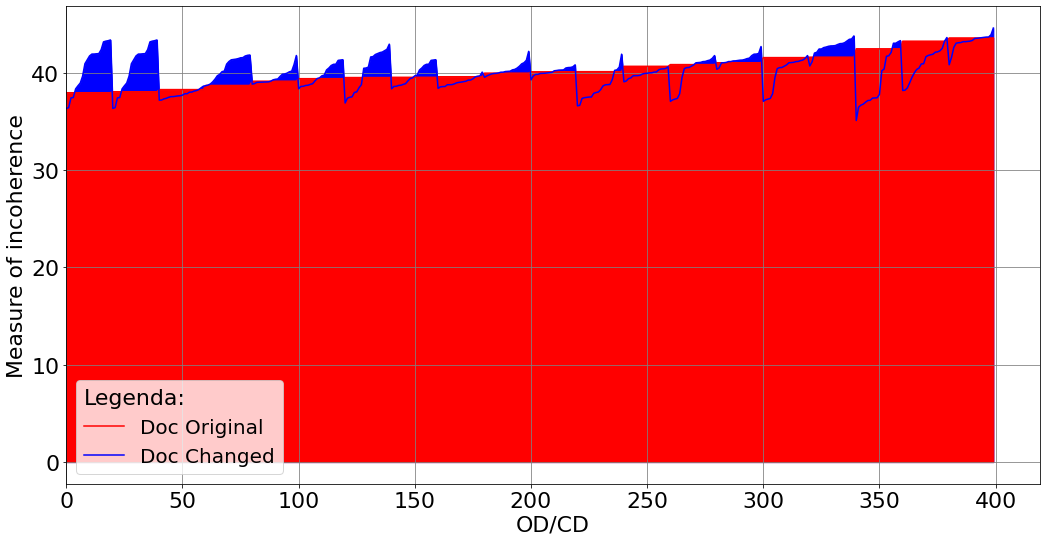

In [ ]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

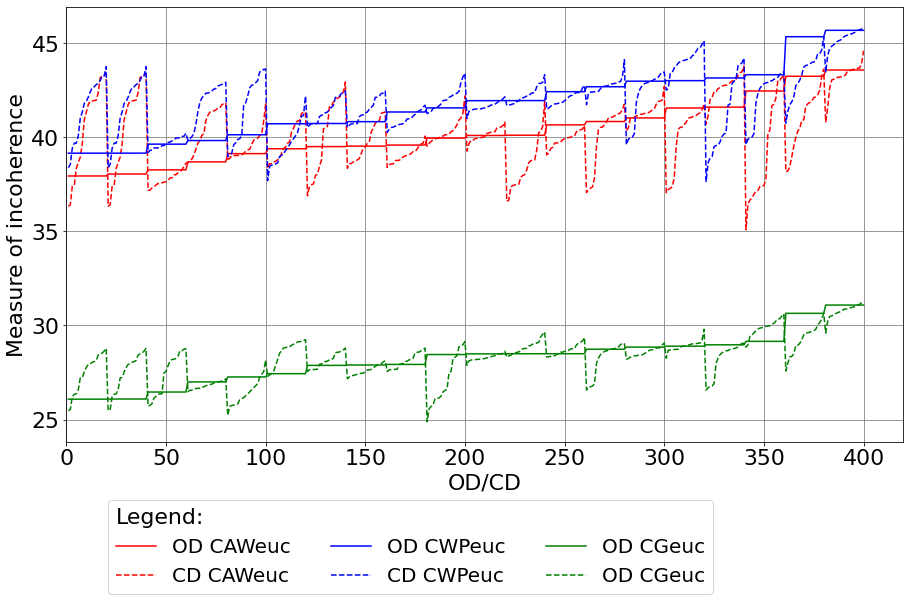

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [ ]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 546.662814341577
Diferença absoluta entre as medidas equação CWP : 454.9634582252345
Diferença absoluta entre as medidas equação CG  : 288.86682417118817


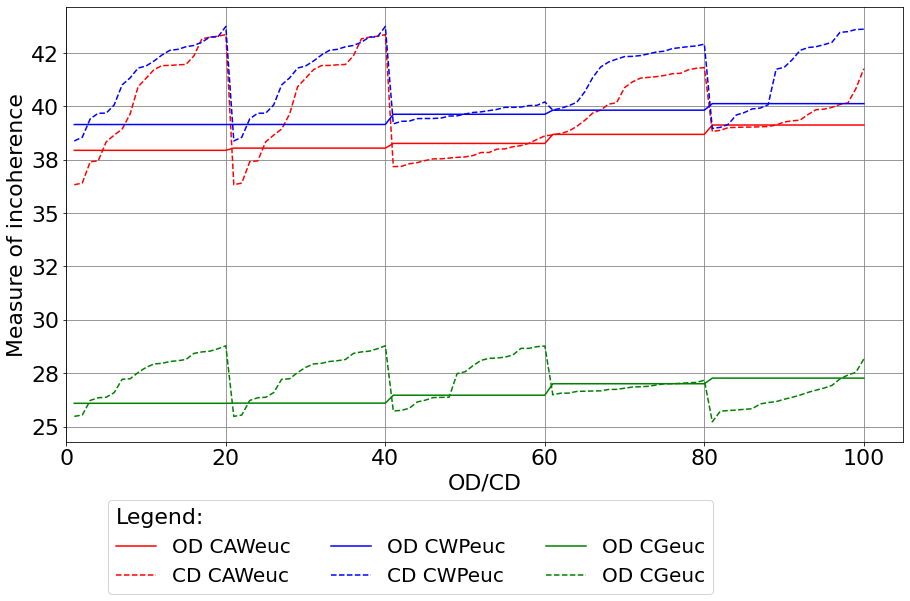

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

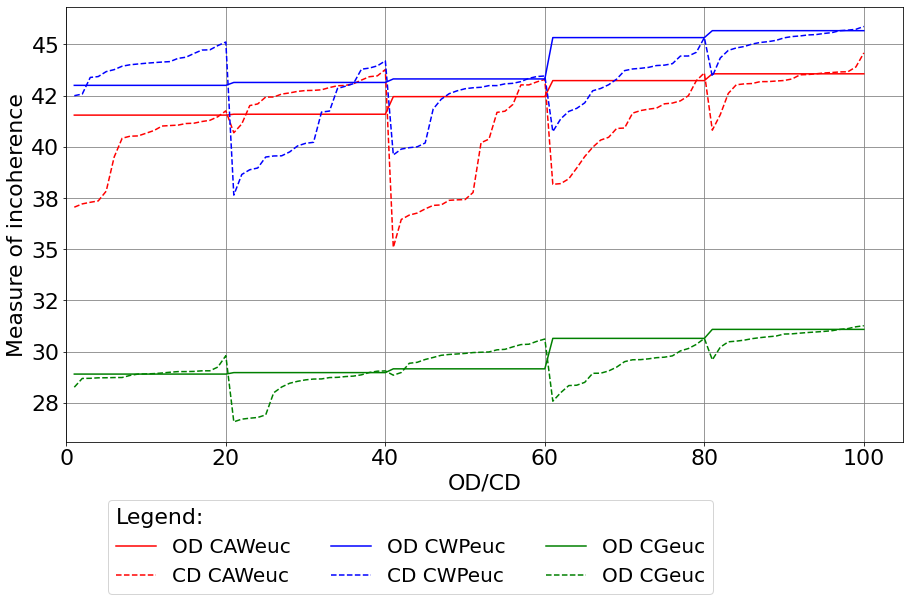

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

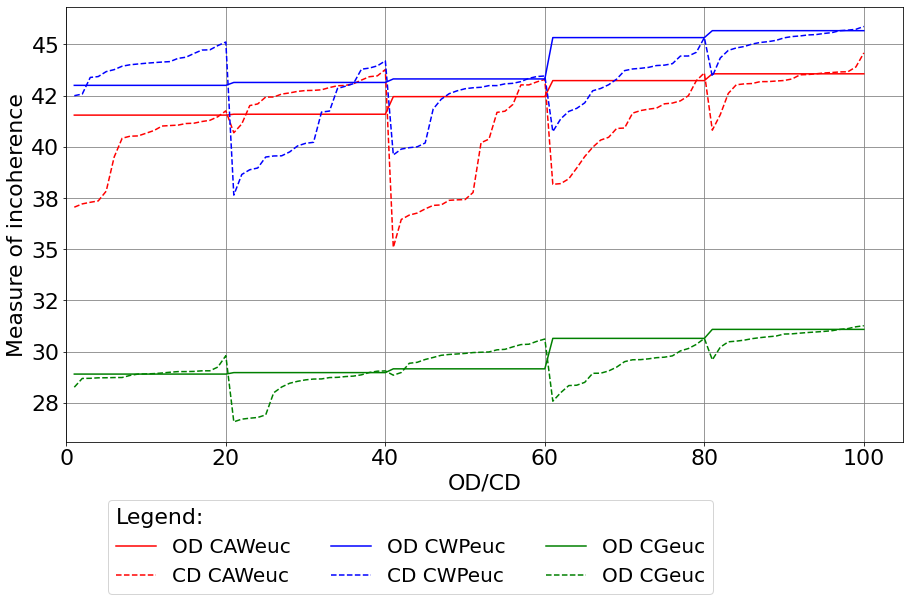

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

# DO central do gráfico com a maior diferença
# idDO = 3
# difabs= 66.91955484662748, 
# 'How to push elements in a stack?'
# Posição gráfico 18 * 20 = 360

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 546.662814341577

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 5.828973423350945, 11, 'In a queue does the enqueue operation occur at which end?']
['19', 9.005291505293464, 15, 'In a stack does the pop operation occur at which end?']
['12', 9.349364598592054, 10, 'What is a stack and how to pop an element from it?']
['17', 10.634785872239355, 20, 'How are the operations to push and pop elements in a stack implemented?']
['18', 10.81030009343074, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 39.90215819222586, 7, 'How to pop elements from a stack?']
['6', 46.575043244795296, 19, 'How to push and pop elements in a stack data structure?']
['2', 58.58945083618163, 2, 'How

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 260.6730254578184

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.20822991265190893, 16, 'How to push elements in a stack data structure?']
['6', 0.3757809725674761, 19, 'How to push and pop elements in a stack data structure?']
['10', 0.5396219253540124, 3, 'What is a queue and how to enqueue its element?']
['9', 0.6277305603027372, 9, 'What is a stack and how to push its element?']
['17', 1.6524124145507955, 20, 'How are the operations to push and pop elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 22.39452727635699, 17, 'What is a stack and how to push and pop its elements?']
['7', 26.38645471845

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> group(CAWeuc(pertDO)=38,9

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 285.9897888837584

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.02373981475830078, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['12', 1.044405619303447, 10, 'What is a stack and how to pop an element from it?']
['18', 1.1299362182617827, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['19', 1.2093105316161967, 15, 'In a stack does the pop operation occur at which end?']
['15', 1.3781956036885674, 17, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 19.957387924194293, 14, 'How to pop elements in a stack data structur

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
# id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 454.9634582252345

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 5.034560394287098, 3, 'What is a queue and how to enqueue its element?']
['19', 5.96811051802198, 14, 'In a stack does the pop operation occur at which end?']
['20', 6.768554745298488, 11, 'In a queue does the enqueue operation occur at which end?']
['12', 8.159462879865558, 12, 'What is a stack and how to pop an element from it?']
['14', 8.672429867279838, 13, 'What is a stack and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 40.34382521800503, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['6', 40.81319297443733, 19, 'How to push and pop elements in a stack data structure?']
['3', 48.23435769762305, 17, 'How to push elements in a 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 252.59494672773766

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.29235810173882015, 18, 'How to push elements in a stack data structure?']
['17', 0.2968035058660732, 20, 'How are the operations to push and pop elements in a stack implemented?']
['20', 0.3076264930493835, 11, 'In a queue does the enqueue operation occur at which end?']
['14', 0.5398884553175733, 13, 'What is a stack and how to push an element on it?']
['9', 0.7979520971124856, 9, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 21.495841931074153, 16, 'What is a stack and how to push and pop its elements?']
['7', 32.

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a queue ? [enqueue(CWPeuc(DO)=39,1498506410) -> organize(>CWPeuc(pertDO)=38,3811018808)] - VERB/VERB-1-0
  2 - How to use elements in a queue ? [enqueue(CWPeuc(DO)=39,1498506410) -> use(>CWPeuc(pertDO)=38,5545558929)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> arrange(CWPeuc(pertDO)=39,4187649318)] - VERB/VERB-1-0
  4 - How to put elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> put(CWPeuc(pertDO)=39,6786402294)] - VERB/VERB-1-0
  5 - How to store elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> store(CWPeuc(pertDO)=39,6815622875)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> place(CWPeuc(pertDO)=40,0689068522)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> group(CWPeuc(pertDO)=41,0

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 202.36851149749683

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 0.3308937610724101, 7, 'What is a queue and how to dequeue an element in it?']
['18', 0.7868996190500752, 10, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['13', 0.9166506253756168, 8, 'What is a queue and how to enqueue an element in it?']
['15', 0.929393817216912, 16, 'What is a stack and how to push and pop its elements?']
['12', 1.1239338654738589, 12, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 17.91067246331111, 15, 'How to pop elements in a stack data structure?']
['

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> organize(>CWPeuc(pertDO)=37,6427433831)] - VERB/VERB-1-0
  2 - How to stack elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> stack(>CWPeuc(pertDO)=38,6504412379)] - VERB/NOUN-0-0
  3 - How to store elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> store(>CWPeuc(pertDO)=38,8817342349)] - VERB/VERB-1-0
  4 - How to arrange elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> arrange(>CWPeuc(pertDO)=38,9668880190)] - VERB/VERB-1-0
  5 - How to combine elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> combine(>CWPeuc(pertDO)=39,5025003978)] - VERB/VERB-1-0
  6 - How to handle elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> handle(>CWPeuc(pertDO)=39,5537834849)] - VERB/VERB-1-0
  7 - How to place elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> place(>CWPeuc(pertDO)=39,5619644438)

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 288.86682417118817

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19', 3.9330929120381697, 16, 'In a stack does the pop operation occur at which end?']
['10', 4.289674585515797, 4, 'What is a queue and how to enqueue its element?']
['20', 4.304771900177002, 11, 'In a queue does the enqueue operation occur at which end?']
['12', 5.327291635366567, 13, 'What is a stack and how to pop an element from it?']
['14', 6.128687491783747, 15, 'What is a stack and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 24.153702497482332, 3, 'How to pop elements from a stack?']
['6', 27.197179953257262, 19, 'How to push and pop elements in a stack data structure?']
['1', 29.77384948730468, 2, 'How to enqueue elements in a queue?']
['2', 29.90721

###### Usando CGP onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 148.2409732739368

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.15842933654785085, 17, 'How to push elements in a stack data structure?']
['20', 0.17985026041666785, 11, 'In a queue does the enqueue operation occur at which end?']
['10', 0.29682038047097237, 4, 'What is a queue and how to enqueue its element?']
['14', 0.3340256030742843, 15, 'What is a stack and how to push an element on it?']
['17', 0.34405326843261363, 20, 'How are the operations to push and pop elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 15.012972318209172, 18, 'What is a stack and how to push and pop its elements?']
['7',

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [dequeue(CGeuc(DO)=26,0871255398) -> use(>CGeuc(pertDO)=25,4749939442)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [dequeue(CGeuc(DO)=26,0871255398) -> organize(>CGeuc(pertDO)=25,5374321938)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> arrange(CGeuc(pertDO)=26,2221984863)] - VERB/VERB-1-0
  4 - How to put elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> put(CGeuc(pertDO)=26,3478198051)] - VERB/VERB-1-0
  5 - How to store elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> store(CGeuc(pertDO)=26,3699717522)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> place(CGeuc(pertDO)=26,5881965160)] - VERB/VERB-1-0
  7 - How to create elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> create(CGeuc(pertDO)=27,2136938572)] 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;How to place elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
2_pert_1;How to arrange elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
2_pert_2;How to organize elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
2_pert_3;How to manage elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
2_pert_4;How to put elements in 

###### Usando CGP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 140.6258508972516

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.21679482093225033, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['18', 0.3752475466047045, 12, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['15', 0.48951911926269176, 18, 'What is a stack and how to push and pop its elements?']
['12', 0.749459633460404, 13, 'What is a stack and how to pop an element from it?']
['2', 1.1618249416351318, 1, 'How to dequeue elements in a queue?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8', 11.98199424743655, 14, 'How to pop elements in a stack data structure?']
['5', 15.7205

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> organize(>CGeuc(pertDO)=24,8844165802)] - VERB/VERB-1-0
  2 - How to stack elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> stack(>CGeuc(pertDO)=25,5725605488)] - VERB/NOUN-0-0
  3 - How to store elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> store(>CGeuc(pertDO)=25,6991407871)] - VERB/VERB-1-0
  4 - How to arrange elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> arrange(>CGeuc(pertDO)=25,7810807228)] - VERB/VERB-1-0
  5 - How to combine elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> combine(>CGeuc(pertDO)=26,1128931046)] - VERB/VERB-1-0
  6 - How to place elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> place(>CGeuc(pertDO)=26,1368505955)] - VERB/VERB-1-0
  7 - How to handle elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> handle(>CGeuc(pertDO)=26,1475732327)] - VERB/VERB-

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 140.6258508972516

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.8304439891468363, 11, 'In a queue does the enqueue operation occur at which end?']
['10', 1.0873889923095703, 3, 'What is a queue and how to enqueue its element?']
['9', 1.1938701629638686, 9, 'What is a stack and how to push its element?']
['14', 1.5950396855672153, 13, 'What is a stack and how to push an element on it?']
['19', 1.6641571738503202, 15, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 4.4964597490098726, 16, 'How to push elements in a stack data structure?']
['6', 5.065876353870735, 19, 'How to push and pop elements in a stack data structure?']
['2', 5.318277631487

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 140.6258508972516

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.20822991265190893, 16, 'How to push elements in a stack data structure?']
['10', 0.35238971710204936, 3, 'What is a queue and how to enqueue its element?']
['6', 0.3757809725674761, 19, 'How to push and pop elements in a stack data structure?']
['9', 0.47918910980224894, 9, 'What is a stack and how to push its element?']
['20', 0.7136334505948128, 11, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['18', 2.6382076556865997, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 3.12906010

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> group(CAWeuc(pertDO)=38,9

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 140.6258508972516

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.02373981475830078, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['18', 0.3030709486741401, 5, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 0.43015146255493875, 10, 'What is a stack and how to pop an element from it?']
['19', 0.6797554709694538, 15, 'In a stack does the pop operation occur at which end?']
['20', 0.8304439891468363, 11, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 3.5106018914116746, 12, 'How to push and pop elements in a stack?']
['8',

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 140.6258508972516

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.5781727530739502, 3, 'What is a queue and how to enqueue its element?']
['14', 0.9269843468299328, 13, 'What is a stack and how to push an element on it?']
['20', 0.9458628278790115, 11, 'In a queue does the enqueue operation occur at which end?']
['9', 1.08734123923562, 9, 'What is a stack and how to push its element?']
['12', 1.3723410337399145, 12, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 3.7111725277370837, 18, 'How to push elements in a stack data structure?']
['6', 4.589181322039977, 19, 'How to push and pop elements in a stack data structure?']
['2', 4.590863568442209, 

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 140.6258508972516

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.1448192596435547, 18, 'How to push elements in a stack data structure?']
['17', 0.20437814901163165, 20, 'How are the operations to push and pop elements in a stack implemented?']
['20', 0.20763466574928913, 11, 'In a queue does the enqueue operation occur at which end?']
['14', 0.3354234450902709, 13, 'What is a stack and how to push an element on it?']
['9', 0.3583186756480856, 9, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 2.1164899728237074, 16, 'What is a stack and how to push and pop its elements?']
['16', 3.0952114692101

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> group(CAWeuc(pertDO)=38,9

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 140.6258508972516

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11', 0.20794376960167682, 7, 'What is a queue and how to dequeue an element in it?']
['12', 0.25597760616205534, 12, 'What is a stack and how to pop an element from it?']
['18', 0.3027991410140132, 10, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['13', 0.30563635703845193, 8, 'What is a queue and how to enqueue an element in it?']
['10', 0.4512121027166174, 3, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 3.021292792426216, 6, 'How to push and pop elements in a stack?']
['8', 3.368937513563367, 1

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 140.6258508972516

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 0.518332047895953, 4, 'What is a queue and how to enqueue its element?']
['20', 0.6099414825439453, 11, 'In a queue does the enqueue operation occur at which end?']
['14', 0.6433908022367056, 15, 'What is a stack and how to push an element on it?']
['9', 0.7314655997536406, 8, 'What is a stack and how to push its element?']
['12', 0.8594527611365699, 13, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 2.4038806915283253, 17, 'How to push elements in a stack data structure?']
['1', 2.6861772537231445, 2, 'How to enqueue elements in a queue?']
['2', 2.694512367248535, 1, 'How to dequeue el

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 140.6258508972516

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.08283081054687358, 17, 'How to push elements in a stack data structure?']
['20', 0.1455866495768241, 11, 'In a queue does the enqueue operation occur at which end?']
['10', 0.1661673459139763, 4, 'What is a queue and how to enqueue its element?']
['17', 0.17956107003348265, 20, 'How are the operations to push and pop elements in a stack implemented?']
['14', 0.21669387817382102, 15, 'What is a stack and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 1.4560651045579185, 18, 'What is a stack and how to push and pop its elements?']
['16', 1.8068721477

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [dequeue(>CAWeuc(DO)=38,0434188843) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [dequeue(>CAWeuc(DO)=38,0434188843) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [dequeue(>CAWeuc(DO)=38,0434188843) -> group(CAWeuc(pertDO)=38,9

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;How to place elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
2_pert_1;How to arrange elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
2_pert_2;How to organize elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
2_pert_3;How to manage elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
2_pert_4;How to put elements in 

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 140.6258508972516

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.15078691335825312, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['12', 0.1761913299560547, 13, 'What is a stack and how to pop an element from it?']
['18', 0.1862867900303442, 12, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['15', 0.3098314725435678, 18, 'What is a stack and how to push and pop its elements?']
['11', 0.3249582143930354, 7, 'What is a queue and how to dequeue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['4', 2.048616981506349, 5, 'How to push and pop elements in a stack?']
['8', 2.1705671

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [ ]:
medida = 'man'

### Estatística

#### CAW

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 125 de 400
Percentual de documentos coerentes em relação ao total: 31.25
Acertos Perturbado : 275 de 400
Percentual de documentos incoerentes em relação ao total: 68.75


#### CWP

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 147 de 400
Percentual de documentos coerentes em relação ao total: 36.75
Acertos Perturbado : 253 de 400
Percentual de documentos incoerentes em relação ao total: 63.24999999999999


#### CG

In [ ]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 133 de 400
Percentual de documentos coerentes em relação ao total: 33.25
Acertos Perturbado : 267 de 400
Percentual de documentos incoerentes em relação ao total: 66.75


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [ ]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to position elements in a queue ?
2;How to create elements in a queue ?
3;How to connect elements in a stack ?
4;How to throw and pop elements in a stack ?
5;How to sort elements in a stack data structure ?
6;How to drag and pop elements in a stack data structure ?
7;How to construct elements from a stack ?
8;How to write elements in a stack data structure ?
9;What is a stack and how to count its element ?
10;What is a queue and how to select its element ?
11;What is a queue and how to keep an element in it ?
12;What is a stack and how to remove an element from it ?
13;What is a queue and how to sort an element in it ?
14;What is a stack and how to construct an element on it ?
15;What is a stack and how to push and drop its elements ?
16;What is a queue and how to enqueue and control its elements ?
17;How are the operations to drag and pop elements in a stack implemented ?
18;How are the operations to enqueue and dequeue elements in a queue connected ?
19;In a stack does the pop 

### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





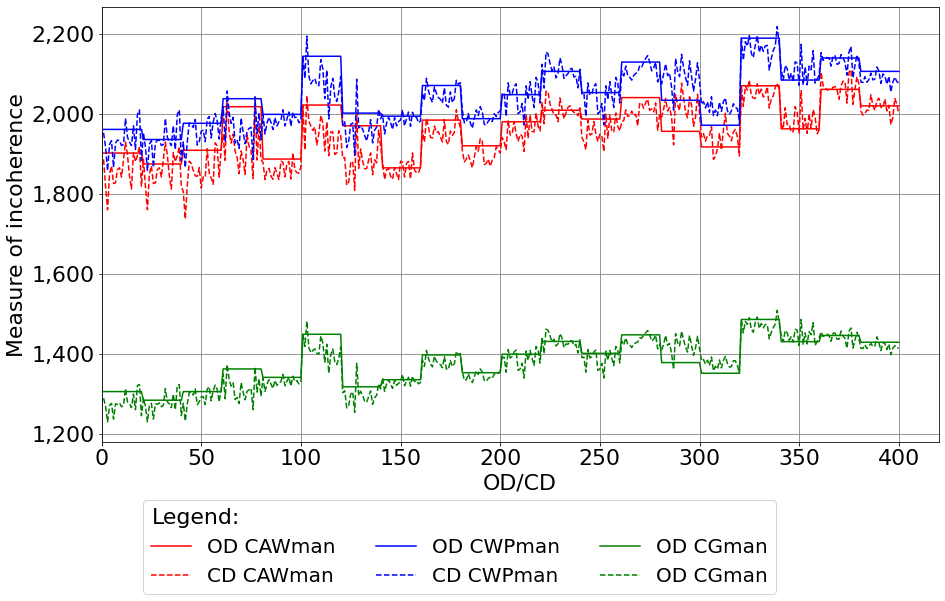

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [ ]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 15861.669279390046
Diferença entre as equação CWP      : 12883.721805669029
Diferença entre as equação CG       : 8763.755420432068


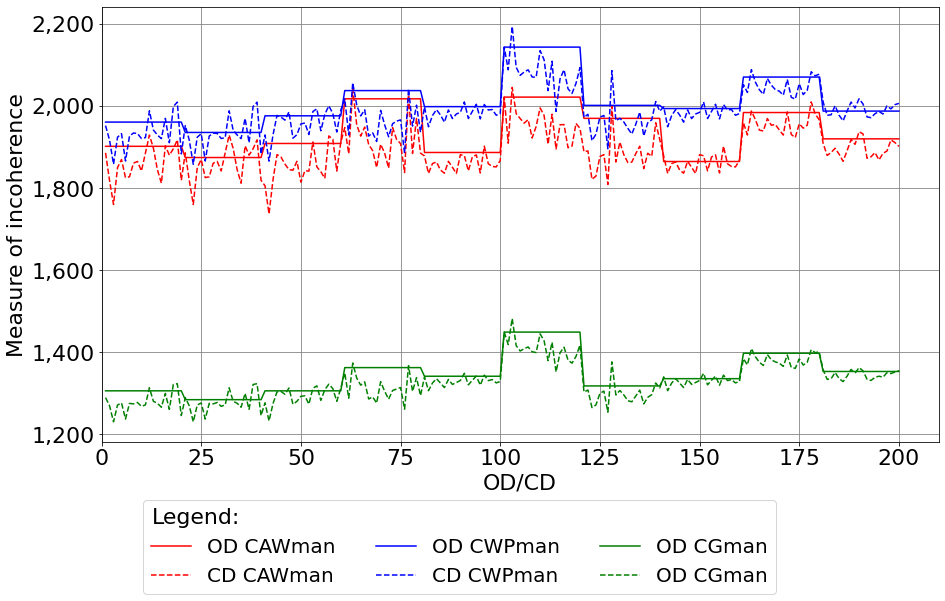

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

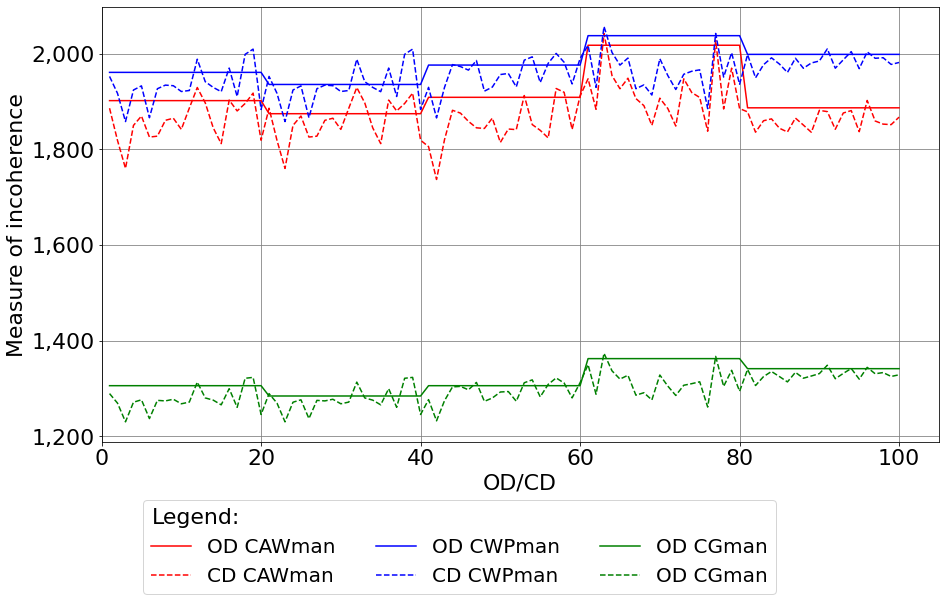

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

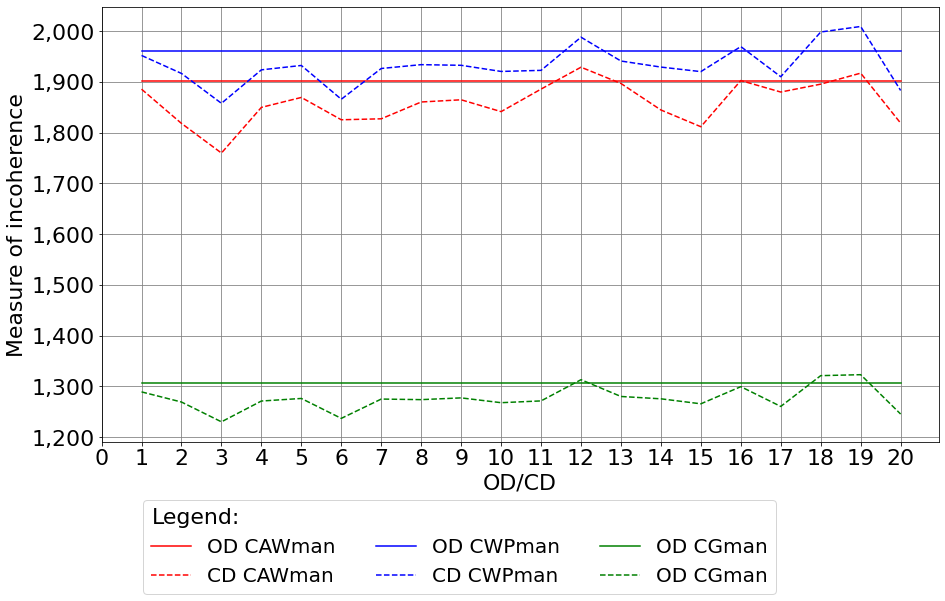

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

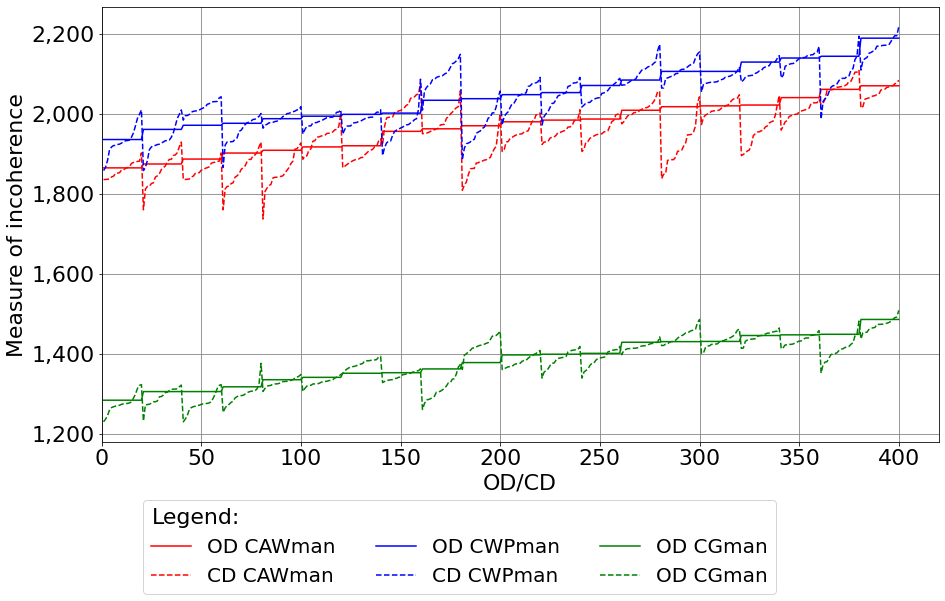

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

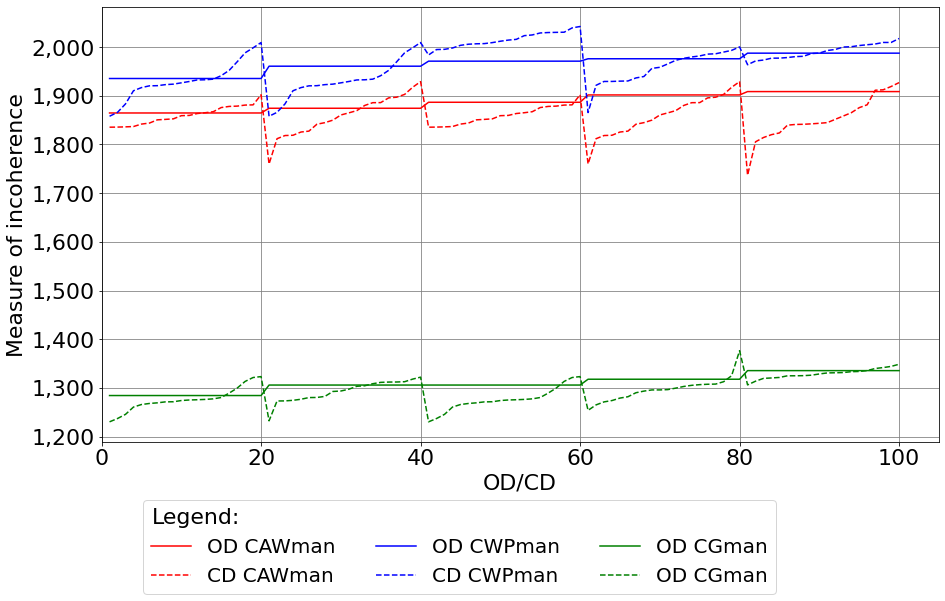

In [ ]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

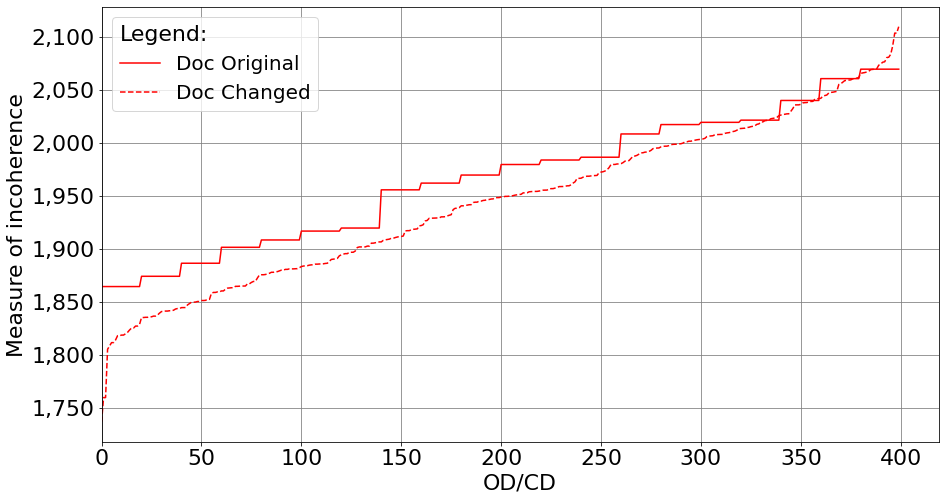

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

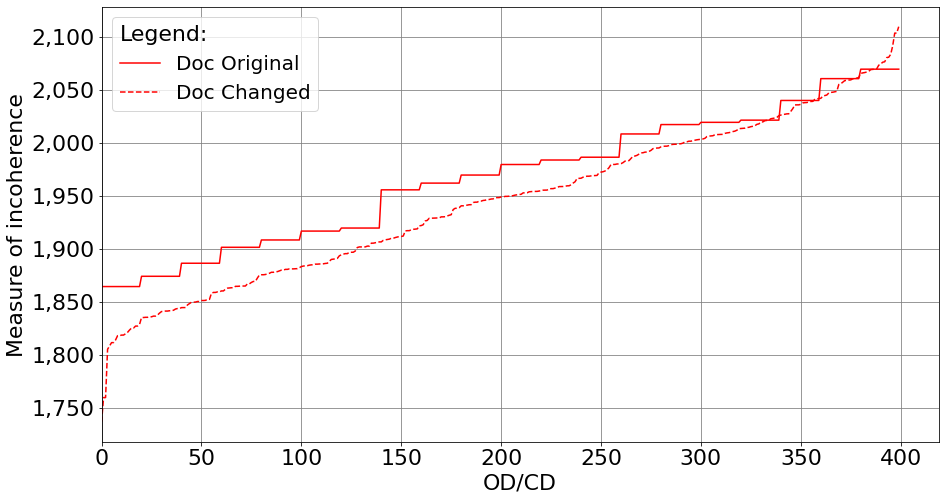

In [ ]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

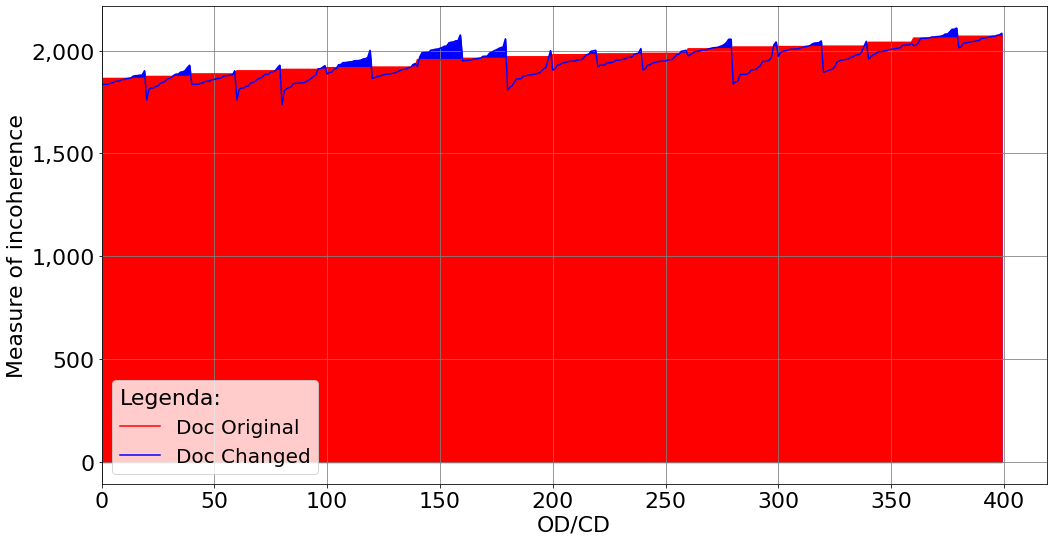

In [ ]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 15861.669279390046

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 307.742418181816, 16, 'In a queue does the enqueue operation occur at which end?']
['8', 321.2357777777788, 1, 'How to pop elements in a stack data structure?']
['12', 330.6598249999995, 14, 'What is a stack and how to pop an element from it?']
['19', 356.6285181818164, 19, 'In a stack does the pop operation occur at which end?']
['17', 385.01072307692675, 20, 'How are the operations to push and pop elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 1187.7371428571428, 5, 'How to push elements in a stack?']
['15', 1189.6544166666663, 8, 'What is a stack and how to push and pop its elements?']
['6', 1389.9341727272672, 17, 'How to push and pop elements in a s

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 3331.6251296914106

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 15.383877777778025, 3, 'How to push elements in a stack data structure?']
['6', 23.6912636363636, 17, 'How to push and pop elements in a stack data structure?']
['17', 25.93735384615411, 20, 'How are the operations to push and pop elements in a stack implemented?']
['10', 29.491780000000063, 7, 'What is a queue and how to enqueue its element?']
['7', 30.127457142857565, 10, 'How to pop elements from a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 199.1350999999986, 2, 'How to dequeue elements in a queue?']
['19', 255.69624545454326, 19, 'In a stack does the po

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 12530.044149698622

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 33.701483333333044, 8, 'What is a stack and how to push and pop its elements?']
['18', 55.882392307691816, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16', 89.58070833333522, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['19', 100.93227272727313, 19, 'In a stack does the pop operation occur at which end?']
['12', 137.62937499999862, 14, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 891.2456714285672, 4, 'How to enqueue elements in a queue?']
['3', 115

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to stack and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> stack(>CAWman(pertDO)=1837,8163777778)] - VERB/NOUN-0-0
  2 - How to create and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> create(>CAWman(pertDO)=1848,6216333333)] - VERB/VERB-1-0
  3 - How to trap and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> trap(>CAWman(pertDO)=1850,0916555556)] - VERB/VERB-1-0
  4 - How to combine and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> combine(>CAWman(pertDO)=1883,6236111111)] - VERB/VERB-1-0
  5 - How to write and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> write(>CAWman(pertDO)=1884,3337333333)] - VERB/VERB-1-0
  6 - How to layer and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> layer(>CAWman(pertDO)=1885,1910222222)] - VERB/VERB-1-0
  7 - How to use and pop elements

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;How to mix and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;mix;VERB;1947,4194111111;2017,2973200000;1349,7309000000;0,2388779521;0;1
4_pert_1;How to combine and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;combine;VERB;1883,6236111111;1929,4046177778;1287,8964600000;0,0675081611;0;1
4_pert_2;How to throw and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;throw;VERB;2042,1681555556;2056,7698022222;1373,4772100000;0,0290309936;0;1
4_pert_3;How to put and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;put;VERB;1954,1022777778;2002,49086222

#### Usando CWP

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 12883.721805669029

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 262.5742109090902, 5, 'What is a queue and how to enqueue its element?']
['19', 280.1366999999982, 18, 'In a stack does the pop operation occur at which end?']
['8', 294.6850777777777, 6, 'How to pop elements in a stack data structure?']
['5', 351.0187444444514, 7, 'How to push elements in a stack data structure?']
['12', 374.6120115384624, 15, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 875.0826743589887, 3, 'What is a queue and how to enqueue and dequeue its elements?']
['7', 923.8112357142813, 8, 'How to pop elements from a stack?']
['15', 1288.7236019230907, 9, 'What is a stack and how to push and pop its elements?']
['6', 1

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 4253.63297682373

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 11.989758181816796, 16, 'In a queue does the enqueue operation occur at which end?']
['5', 22.41808666666452, 7, 'How to push elements in a stack data structure?']
['4', 23.887971111110573, 10, 'How to push and pop elements in a stack?']
['14', 25.833402564099288, 17, 'What is a stack and how to push an element on it?']
['8', 40.56851999999958, 6, 'How to pop elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11', 213.42539230769398, 11, 'What is a queue and how to dequeue an element in it?']
['2', 246.39582857142523, 1, 'How to dequeue e

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CWPman(DO)=2033,6013538462) -> grab(>CWPman(pertDO)=2009,1158461538)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CWPman(DO)=2033,6013538462) -> lock(CWPman(pertDO)=2056,4807358974)] - VERB/VERB-1-0
  3 - What is a stack and how to push and shove its elements ? [pop(>CWPman(DO)=2033,6013538462) -> shove(CWPman(pertDO)=2065,3970653846)] - VERB/VERB-1-0
  4 - What is a stack and how to push and manipulate its elements ? [pop(>CWPman(DO)=2033,6013538462) -> manipulate(CWPman(pertDO)=2071,1733666667)] - VERB/VERB-1-0
  5 - What is a stack and how to push and pull its elements ? [pop(>CWPman(DO)=2033,6013538462) -> pull(CWPman(pertDO)=2074,6235307692)] - VERB/VERB-1-0
  6 - What is a stack and how to push and shift its elements ? [pop(>CWPman(DO)=

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 8630.088828845288

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 24.485507692307692, 9, 'What is a stack and how to push and pop its elements?']
['18', 48.94478505494499, 14, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['10', 97.81961272727995, 5, 'What is a queue and how to enqueue its element?']
['12', 164.98400128206367, 15, 'What is a stack and how to pop an element from it?']
['19', 193.43775151514683, 18, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['17', 510.1515246153908, 20, 'How are the operations to push and pop elements in a sta

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to stack and pop elements in a stack ? [push(CWPman(DO)=2037,5589666667) -> stack(>CWPman(pertDO)=1884,9301546667)] - VERB/NOUN-0-0
  2 - How to trap and pop elements in a stack ? [push(CWPman(DO)=2037,5589666667) -> trap(>CWPman(pertDO)=1913,4776666667)] - VERB/VERB-1-0
  3 - How to create and pop elements in a stack ? [push(CWPman(DO)=2037,5589666667) -> create(>CWPman(pertDO)=1925,0061911111)] - VERB/VERB-1-0
  4 - How to gather and pop elements in a stack ? [push(CWPman(DO)=2037,5589666667) -> gather(>CWPman(pertDO)=1926,6700688889)] - VERB/VERB-1-0
  5 - How to combine and pop elements in a stack ? [push(CWPman(DO)=2037,5589666667) -> combine(>CWPman(pertDO)=1929,4046177778)] - VERB/VERB-1-0
  6 - How to arrange and pop elements in a stack ? [push(CWPman(DO)=2037,5589666667) -> arrange(>CWPman(pertDO)=1934,6228533333)] - VERB/VERB-1-0
  7 - How to layer and pop 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;How to mix and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;mix;VERB;1947,4194111111;2017,2973200000;1349,7309000000;0,2388779521;0;1
4_pert_1;How to combine and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;combine;VERB;1883,6236111111;1929,4046177778;1287,8964600000;0,0675081611;0;1
4_pert_2;How to throw and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;throw;VERB;2042,1681555556;2056,7698022222;1373,4772100000;0,0290309936;0;1
4_pert_3;How to put and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;put;VERB;1954,1022777778;2002,49086222

#### Usando CG

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 8763.755420432068

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 193.51988000000074, 5, 'How to pop elements in a stack data structure?']
['19', 200.7491500000001, 17, 'In a stack does the pop operation occur at which end?']
['10', 209.05932727272375, 8, 'What is a queue and how to enqueue its element?']
['20', 229.36054583333134, 14, 'In a queue does the enqueue operation occur at which end?']
['12', 249.2998076923077, 16, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 547.2302750000003, 4, 'How to pop elements from a stack?']
['1', 672.4001224999988, 3, 'How to enqueue elements in a queue?']
['6', 856.1786916666683, 19, 'How to push and pop elements in a stack data structure?']
['15', 907.057353846

###### Usando CGP onde Cm(pertDO)>Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 2502.9532136771686

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 10.225720000000365, 6, 'How to push elements in a stack data structure?']
['20', 13.64144500000043, 14, 'In a queue does the enqueue operation occur at which end?']
['4', 15.69932999999969, 9, 'How to push and pop elements in a stack?']
['14', 16.148215384614787, 18, 'What is a stack and how to push an element on it?']
['10', 22.32142727272867, 8, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['12', 124.38034615384959, 16, 'What is a stack and how to pop an element from it?']
['2', 125.21291250000058, 1, 'How to dequeue ele

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CGman(DO)=1378,2652923077) -> grab(>CGman(pertDO)=1361,0997538462)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CGman(DO)=1378,2652923077) -> lock(CGman(pertDO)=1396,5423153846)] - VERB/VERB-1-0
  3 - What is a stack and how to push and shove its elements ? [pop(>CGman(DO)=1378,2652923077) -> shove(CGman(pertDO)=1400,3038923077)] - VERB/VERB-1-0
  4 - What is a stack and how to push and manipulate its elements ? [pop(>CGman(DO)=1378,2652923077) -> manipulate(CGman(pertDO)=1404,6188692308)] - VERB/VERB-1-0
  5 - What is a stack and how to push and pull its elements ? [pop(>CGman(DO)=1378,2652923077) -> pull(CGman(pertDO)=1408,6402923077)] - VERB/VERB-1-0
  6 - What is a stack and how to push and shift its elements ? [pop(>CGman(DO)=1378,265292

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

###### Usando CGP onde Cm(pertDO)<Cm(DO)

In [ ]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 6260.802206754894

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.37879923076934574, 7, 'What is a queue and how to enqueue and dequeue its elements?']
['15', 17.165538461538517, 10, 'What is a stack and how to push and pop its elements?']
['18', 32.74500000000012, 15, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['12', 124.91946153845811, 16, 'What is a stack and how to pop an element from it?']
['19', 127.73909999999933, 17, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['13', 340.07291692307194, 13, 'What is a queue and how to enqueue an ele

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to stack and pop elements in a stack ? [push(CGman(DO)=1362,3902700000) -> stack(>CGman(pertDO)=1261,1360100000)] - VERB/NOUN-0-0
  2 - How to trap and pop elements in a stack ? [push(CGman(DO)=1362,3902700000) -> trap(>CGman(pertDO)=1275,9643900000)] - VERB/VERB-1-0
  3 - How to create and pop elements in a stack ? [push(CGman(DO)=1362,3902700000) -> create(>CGman(pertDO)=1285,3368500000)] - VERB/VERB-1-0
  4 - How to gather and pop elements in a stack ? [push(CGman(DO)=1362,3902700000) -> gather(>CGman(pertDO)=1285,9062300000)] - VERB/VERB-1-0
  5 - How to combine and pop elements in a stack ? [push(CGman(DO)=1362,3902700000) -> combine(>CGman(pertDO)=1287,8964600000)] - VERB/VERB-1-0
  6 - How to arrange and pop elements in a stack ? [push(CGman(DO)=1362,3902700000) -> arrange(>CGman(pertDO)=1291,1181600000)] - VERB/VERB-1-0
  7 - How to layer and pop elements in 

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;How to mix and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;mix;VERB;1947,4194111111;2017,2973200000;1349,7309000000;0,2388779521;0;1
4_pert_1;How to combine and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;combine;VERB;1883,6236111111;1929,4046177778;1287,8964600000;0,0675081611;0;1
4_pert_2;How to throw and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;throw;VERB;2042,1681555556;2056,7698022222;1373,4772100000;0,0290309936;0;1
4_pert_3;How to put and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;put;VERB;1954,1022777778;2002,49086222

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 6260.802206754894

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['8', 37.380811111110916, 1, 'How to pop elements in a stack data structure?']
['20', 46.6083818181819, 16, 'In a queue does the enqueue operation occur at which end?']
['12', 47.31864166666719, 14, 'What is a stack and how to pop an element from it?']
['19', 48.99918181818157, 19, 'In a stack does the pop operation occur at which end?']
['5', 51.20349999999985, 3, 'How to push elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 126.38139999999953, 17, 'How to push and pop elements in a stack data structure?']
['1', 141.7511999999997, 4, 'How to enqueue elements in a queue?']
['7', 161.10691428571454, 10, 'How t

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 6260.802206754894

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17', 14.046192307692309, 20, 'How are the operations to push and pop elements in a stack implemented?']
['13', 15.122466666666924, 13, 'What is a queue and how to enqueue an element in it?']
['5', 15.383877777778025, 3, 'How to push elements in a stack data structure?']
['10', 17.434979999999996, 7, 'What is a queue and how to enqueue its element?']
['3', 18.43529999999987, 5, 'How to push elements in a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['19', 48.99918181818157, 19, 'In a stack does the pop operation occur at which end?']
['2', 54.74801428571391, 2, 'How to dequeue ele

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 6260.802206754894

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 12.28384615384607, 9, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['8', 29.20656666666696, 1, 'How to pop elements in a stack data structure?']
['16', 30.866850000000113, 6, 'What is a queue and how to enqueue and dequeue its elements?']
['15', 33.701483333333044, 8, 'What is a stack and how to push and pop its elements?']
['12', 33.82096666666621, 14, 'What is a stack and how to pop an element from it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 126.38139999999953, 17, 'How to push and pop elements in a stack data structure?']
['1', 141

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to stack and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> stack(>CAWman(pertDO)=1837,8163777778)] - VERB/NOUN-0-0
  2 - How to create and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> create(>CAWman(pertDO)=1848,6216333333)] - VERB/VERB-1-0
  3 - How to trap and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> trap(>CAWman(pertDO)=1850,0916555556)] - VERB/VERB-1-0
  4 - How to combine and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> combine(>CAWman(pertDO)=1883,6236111111)] - VERB/VERB-1-0
  5 - How to write and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> write(>CAWman(pertDO)=1884,3337333333)] - VERB/VERB-1-0
  6 - How to layer and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> layer(>CAWman(pertDO)=1885,1910222222)] - VERB/VERB-1-0
  7 - How to use and pop elements

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;How to mix and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;mix;VERB;1947,4194111111;2017,2973200000;1349,7309000000;0,2388779521;0;1
4_pert_1;How to combine and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;combine;VERB;1883,6236111111;1929,4046177778;1287,8964600000;0,0675081611;0;1
4_pert_2;How to throw and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;throw;VERB;2042,1681555556;2056,7698022222;1373,4772100000;0,0290309936;0;1
4_pert_3;How to put and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;put;VERB;1954,1022777778;2002,49086222

#### Usando CWP






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 6260.802206754894

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 30.10035454545323, 5, 'What is a queue and how to enqueue its element?']
['8', 44.38274000000092, 6, 'How to pop elements in a stack data structure?']
['12', 48.63296666666611, 15, 'What is a stack and how to pop an element from it?']
['5', 49.01446666666811, 7, 'How to push elements in a stack data structure?']
['19', 49.67582878787789, 18, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 105.68018571428524, 8, 'How to pop elements from a stack?']
['3', 110.49834285714314, 4, 'How to push elements in a stack?']
['15', 114.79158461538486, 9, 'What is a stack and how to push and pop i

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 6260.802206754894

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 10.989455151514449, 16, 'In a queue does the enqueue operation occur at which end?']
['5', 11.460953333331872, 7, 'How to push elements in a stack data structure?']
['14', 16.066249999998945, 17, 'What is a stack and how to push an element on it?']
['8', 16.092679999999064, 6, 'How to pop elements in a stack data structure?']
['9', 18.005894545454794, 13, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 71.23933974359102, 3, 'What is a queue and how to enqueue and dequeue its elements?']
['2', 73.87284999999974, 1, 'How to dequeue el

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 6260.802206754894

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 13.00029890109954, 14, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['10', 23.766063636363924, 5, 'What is a queue and how to enqueue its element?']
['15', 24.485507692307692, 9, 'What is a stack and how to push and pop its elements?']
['12', 41.65643846153898, 15, 'What is a stack and how to pop an element from it?']
['8', 44.38274000000092, 6, 'How to pop elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1', 102.82642499999997, 2, 'How to enqueue elements in a queue?']
['7', 105.68018571428524, 8, 'How to pop e

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to scratch and pop elements in a stack data structure ? [push(CAWman(DO)=2021,6959181818) -> scratch(>CAWman(pertDO)=1895,3145181818)] - VERB/VERB-1-0
  2 - How to stick and pop elements in a stack data structure ? [push(CAWman(DO)=2021,6959181818) -> stick(>CAWman(pertDO)=1898,2797090909)] - VERB/VERB-1-0
  3 - How to try and pop elements in a stack data structure ? [push(CAWman(DO)=2021,6959181818) -> try(>CAWman(pertDO)=1902,1358363636)] - VERB/VERB-1-0
  4 - How to jam and pop elements in a stack data structure ? [push(CAWman(DO)=2021,6959181818) -> jam(>CAWman(pertDO)=1906,8442909091)] - VERB/VERB-1-0
  5 - How to pop and pop elements in a stack data structure ? [push(CAWman(DO)=2021,6959181818) -> pop(>CAWman(pertDO)=1909,4259454545)] - VERB/NOUN-0-0
  6 - How to rock and pop elements in a stack data structure ? [push(CAWman(DO)=2021,69

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6
DO: How to push and pop elements in a stack data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6_pert_0;How to push and pop elements in a stack data structure ?;push;VERB;2021,6959181818;2143,5456606061;1448,9510333333;push;VERB;2021,6959181818;2143,5456606061;1448,9510333333;0,1390896142;1;1
6_pert_1;How to pop and pop elements in a stack data structure ?;push;VERB;2021,6959181818;2143,5456606061;1448,9510333333;pop;NOUN;1909,4259454545;2088,2848992424;1418,5726166667;0,0756584257;0;0
6_pert_2;How to drag and pop elements in a stack data structure ?;push;VERB;2021,6959181818;2143,5456606061;1448,9510333333;drag;VERB;2045,3871818182;2193,8321136364;1481,9284500000;0,0710311458;0;1
6_pert_3;How to pull and pop elements in a stack data structure ?;push;VERB;2021,695

#### Usando CG






In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 6260.802206754894

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 24.710763636363026, 8, 'What is a queue and how to enqueue its element?']
['8', 29.336410000000114, 5, 'How to pop elements in a stack data structure?']
['12', 30.88856923076969, 16, 'What is a stack and how to pop an element from it?']
['20', 31.054124999999885, 14, 'In a queue does the enqueue operation occur at which end?']
['19', 32.07965833333333, 17, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 73.4622875, 2, 'How to push elements in a stack?']
['1', 75.55734249999978, 3, 'How to enqueue elements in a queue?']
['15', 78.30583846153854, 10, 'What is a stack and how to push and

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 6260.802206754894

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 7.163580000000138, 6, 'How to push elements in a stack data structure?']
['10', 9.519781818182082, 8, 'What is a queue and how to enqueue its element?']
['14', 10.684092307691799, 18, 'What is a stack and how to push an element on it?']
['4', 11.086939999999686, 9, 'How to push and pop elements in a stack?']
['9', 11.267854545454611, 11, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 38.90810499999998, 1, 'How to dequeue elements in a queue?']
['16', 42.469636923076905, 7, 'What is a queue and how to enqueue and dequeue its elements?']

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [ ]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [ ]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 6260.802206754894

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16', 0.37879923076934574, 7, 'What is a queue and how to enqueue and dequeue its elements?']
['18', 9.86327642857168, 15, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['15', 17.165538461538517, 10, 'What is a stack and how to push and pop its elements?']
['10', 24.710763636363026, 8, 'What is a queue and how to enqueue its element?']
['8', 29.336410000000114, 5, 'How to pop elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 63.95557499999995, 4, 'How to pop elements from a stack?']
['3', 73.4622875, 2, 'How to push e

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [ ]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [ ]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to stack and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> stack(>CAWman(pertDO)=1837,8163777778)] - VERB/NOUN-0-0
  2 - How to create and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> create(>CAWman(pertDO)=1848,6216333333)] - VERB/VERB-1-0
  3 - How to trap and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> trap(>CAWman(pertDO)=1850,0916555556)] - VERB/VERB-1-0
  4 - How to combine and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> combine(>CAWman(pertDO)=1883,6236111111)] - VERB/VERB-1-0
  5 - How to write and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> write(>CAWman(pertDO)=1884,3337333333)] - VERB/VERB-1-0
  6 - How to layer and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> layer(>CAWman(pertDO)=1885,1910222222)] - VERB/VERB-1-0
  7 - How to use and pop elements

In [ ]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;How to mix and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;mix;VERB;1947,4194111111;2017,2973200000;1349,7309000000;0,2388779521;0;1
4_pert_1;How to combine and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;combine;VERB;1883,6236111111;1929,4046177778;1287,8964600000;0,0675081611;0;1
4_pert_2;How to throw and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;throw;VERB;2042,1681555556;2056,7698022222;1373,4772100000;0,0290309936;0;1
4_pert_3;How to put and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;put;VERB;1954,1022777778;2002,49086222

# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:01:04 (h:mm:ss)
